In [1]:
# -*- coding: utf-8 -*- Line 2
#----------------------------------------------------------------------------
# Project     : Price Alarm System Enhancement - Alarm3 - Abnormal Price Detection
# Created By  : Eungi Cho
# Created Date: 07/06/22
# Updated Date: 17/06/22
# version ='2.0'
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import KNNImputer

from tqdm import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

plt.style.use('default')

In [2]:
import pathlib
df_raw = pd.read_csv('/Users/cho-eungi/Practice/CSV/market_entry_price.csv')
df_raw = df_raw.drop_duplicates()
df_raw.head()

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
0,201,South Africa,1487,131,92926374,ZAR,kg,2020-07-20,19.64,21.2,19.956
1,39,India,810,490,41039702,INR,kg,2020-07-06,11.80,12.5,12.200
2,41,India,2188,133,50157058,INR,kg,2020-07-06,50.00,52.7,51.400
3,556,Bangladesh,6581,545,84458922,BDT,kg,2020-07-13,4400.00,4800.0,4600.000
4,150,Turkey,2482,126,58387432,TRY,NaN,2020-07-13,10.00,15.0,11.288


# Data Pre-processsing
Step1: Randomly sampling 100 entries to create 'entry_df'

Step2: Join 'time_df' to each 'entry_df', and make 'df' to reflect the actual frequency of price acquisition

Step3: Use KNN imputer to impute the null value of 'df', and update 'df'

In [157]:
entry_lst = np.sort(df_raw['entry_id'].unique())
np.random.seed(0)
sample_entry = np.random.choice(entry_lst, 3000)
# sample_entry = [58650041, 41111413, 58670675, 58655008]

# test_df = sample_entry dataframe - before time_df join
test_df = df_raw.loc[df_raw['entry_id'].isin(sample_entry)].sort_values(
    by = ['source_id', 'market_id', 'entry_id', 'date']).copy()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df

,source_id,country,market_id,product_id,entry_id,currency,final_unit,date,price_min,price_max,price_avg
187481,1,Canada,62,112,41761092,USD,pound,2020-11-30,29.98,29.98,29.98
207456,1,Canada,62,112,41761092,USD,pound,2020-12-14,42.89,42.89,42.89
8754,1,Canada,62,112,41761092,USD,pound,2020-12-28,31.72,31.72,31.72
11076,1,Canada,62,112,41761092,USD,pound,2021-01-11,32.26,32.26,32.26
225567,1,Canada,62,112,41761092,USD,pound,2021-01-18,32.34,32.34,32.34
...,...,...,...,...,...,...,...,...,...,...,...
8883826,745,Taiwan,3455,126,118249447,TWD,kg,2022-03-07,13.10,13.10,13.10
8827092,745,Taiwan,3455,126,118249447,TWD,kg,2022-03-14,16.50,16.50,16.50
8827095,745,Taiwan,3455,126,118249447,TWD,kg,2022-03-28,17.10,17.10,17.10
8827098,745,Taiwan,3455,126,118249447,TWD,kg,2022-04-04,20.40,20.40,20.40


In [158]:
# W-MON date range from 2020 to 2022
# Left Join Test DF and Time DF
empty_df = pd.DataFrame()
for entry in tqdm(sample_entry):
    entry_start = min(df_raw.loc[df_raw['entry_id'] == entry]['date'])
    date_range = pd.date_range(entry_start, '2022-05-31', freq = 'W-MON')
    time_df = pd.DataFrame({'date': date_range})
    
    time_df['entry_id_'] = entry
    entry_df = test_df.loc[test_df['entry_id'] == entry]
    joined_df = pd.merge(time_df, entry_df, left_on = ['date'], right_on = ['date'], how = 'left')
    empty_df = empty_df.append(joined_df)

empty_df = empty_df.drop(['entry_id'], axis = 1)
df = empty_df.copy()
df = df.sort_values(by = ['entry_id_', 'date'])
df.set_index(np.arange(len(df)), inplace=True)
df.head()

100%|█████████████████████████████████████████████| 3000/3000 [02:00<00:00, 24.94it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg
0,2020-01-13,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,269.96,269.96,269.960000
1,2020-01-20,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,269.96,268.657143
2,2020-01-27,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,268.44,268.440000
3,2020-02-03,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.39,268.44,268.404286
4,2020-02-10,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,261.69,268.39,263.604286


In [159]:
# Add price_avg imputed column in df using knn_imputer

# Step1: Change 'date' to categorical data and convert to numerical data
df_temp = df.copy()
df_temp['date_category'] = df_temp['date'].astype('category').cat.codes

# Step2: KNNImpute
imputer_ = KNNImputer(n_neighbors = 2)
def knn_impute_price(date_series, price_series):
    before_imputation = pd.DataFrame({'date':date_series, 'price_avg':price_series})
    imputed = imputer_.fit_transform(before_imputation)
    imputed_price_series = imputed[:, 1]
    return imputed_price_series
imputed_price_series = df_temp.groupby(by = 'entry_id_').progress_apply(
                        lambda df : knn_impute_price(df.date_category, df.price_avg)
                      )
imputed_price_series = pd.Series(np.concatenate(imputed_price_series.values), name = 'price_avg_imputed')
df = pd.concat([df, imputed_price_series], axis = 1)
df.head()

100%|████████████████████████████████████████████| 2984/2984 [00:12<00:00, 247.22it/s]


,date,entry_id_,source_id,country,market_id,product_id,currency,final_unit,price_min,price_max,price_avg,price_avg_imputed
0,2020-01-13,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,269.96,269.96,269.960000,269.960000
1,2020-01-20,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,269.96,268.657143,268.657143
2,2020-01-27,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.44,268.44,268.440000,268.440000
3,2020-02-03,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,268.39,268.44,268.404286,268.404286
4,2020-02-10,40857158,44.0,Belgium,2100.0,164.0,EUR,kg,261.69,268.39,263.604286,263.604286


# Explanatory Data Analysis
step1: null count by entry in 'df'

step2: calculate variability by entry in 'df'

step3: plot sample entry in 'df' with the largest variability

number of unique entry_id in df:  2984
shape of df:  (256675, 12)
number of null price_avg data in each entry: 


100%|███████████████████████████████████████████| 2984/2984 [00:00<00:00, 4122.68it/s]


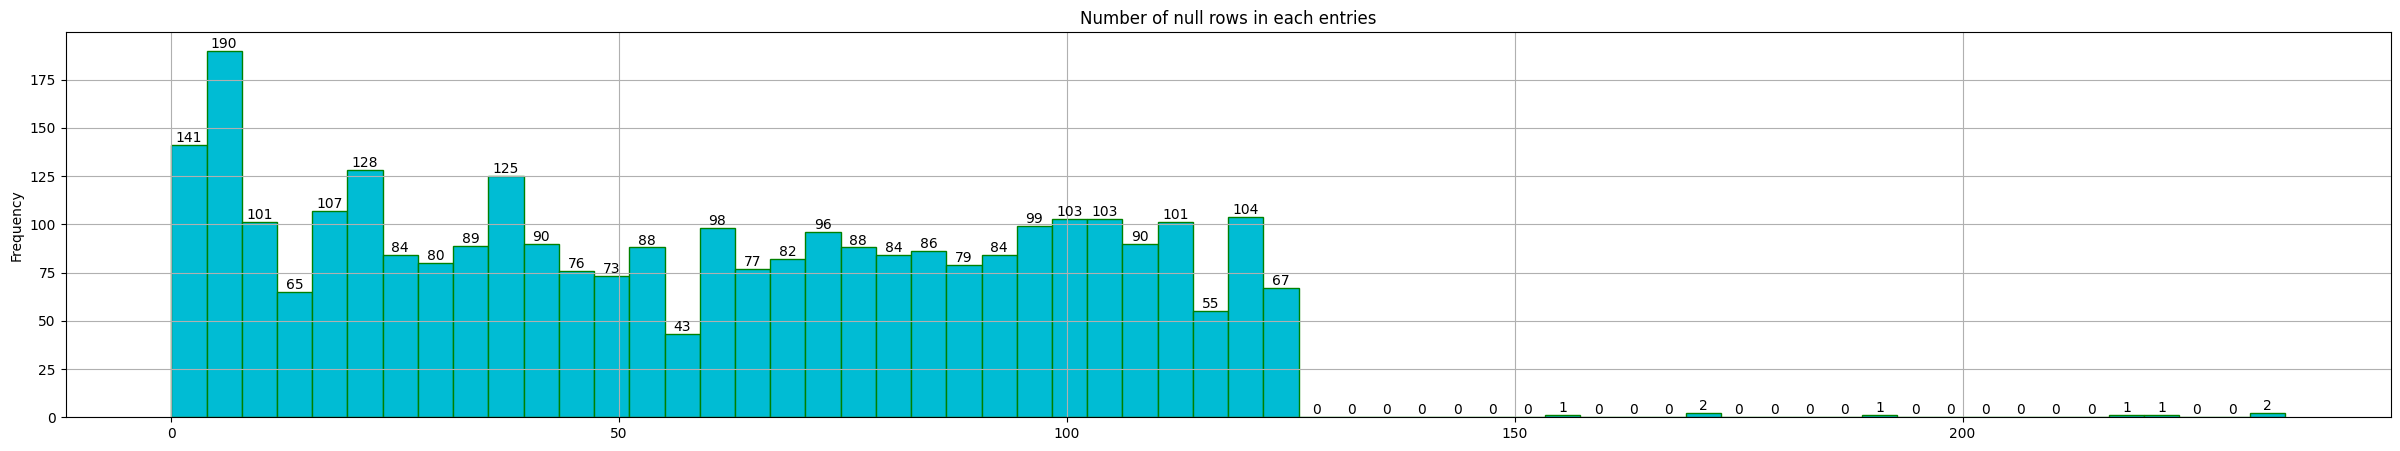

In [160]:
# step1: null count by entry in 'df'
def groupby_count_null(row):
    null_cnt = row.isnull().astype(int).sum()
    return null_cnt

print('number of unique entry_id in df: ', len(df.entry_id_.unique()))
print('shape of df: ', df.shape)
print('number of null price_avg data in each entry: ')

null_cnt_by_entry = df.groupby('entry_id_')['price_avg'].progress_apply(groupby_count_null).sort_values(ascending = False)
ax = null_cnt_by_entry.plot.hist(
    figsize=(30, 5), bins = 60, title='Number of null rows in each entries', 
    fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-', grid=True
)

# ax = null_cnt_by_entry.plot.bar(
#     rot = 45, figsize=(30, 5), title='Number of null rows in each entries', 
#     fontsize=10, color='#00bcd4', edgecolor='g', linestyle='-', 
#     legend=False, grid=True, xlabel='Entry_id', ylabel='Number of rows'
# )
ax.bar_label(ax.containers[0])
plt.style.use('default')
plt.show()

In [161]:
# step2: calculate variability by entry in 'df'

def calculate_volatility(row):
    notnull_row = row.values[~np.isnan(row.values)]
    if len(notnull_row) > 0.5 * len(row):
        chg_rate_lst = [(notnull_row[i] - notnull_row[i-1]) * 100 / notnull_row[i-1] for i in range(1, len(notnull_row))]
        volatility = np.mean(chg_rate_lst)
    else:
        volatility = np.nan
    return volatility

volatility_series = df.groupby('entry_id_')['price_avg'].progress_apply(lambda row: calculate_volatility(row))
print(volatility_series.sort_values(ascending=False)[:10])
print('''

Entry_ID with the largest variability:
''')
print(volatility_series[volatility_series.values == volatility_series.max()])

100%|██████████████████████████████████████████| 2984/2984 [00:00<00:00, 17348.94it/s]

entry_id_
41111413     1983.448913
88453811      457.541561
58644970      142.526007
102332321      44.354276
58650041       38.085612
119398171      37.248316
58670675       37.008938
58639015       34.671631
58650751       34.067249
106649808      32.323795
Name: price_avg, dtype: float64


Entry_ID with the largest variability:

entry_id_
41111413    1983.448913
Name: price_avg, dtype: float64


In [162]:
# Pivot_table
df_pivot = df.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)
df_pivot.head()

price_avg                                                 \
date      2020-01-06 2020-01-13  2020-01-20  2020-01-27  2020-02-03   
entry_id_                                                             
40857158         NaN    269.960  268.657143  268.440000  268.404286   
40857222         NaN      7.410    7.415714    7.437143    7.472857   
40857625       1.400      1.400    1.400000    1.400000    1.353333   
40857869       4.448      4.854    5.225000    5.170000    5.592000   
40857878       1.306      1.324    1.360000    1.446000    1.414000   

                                                                      ...  \
date       2020-02-10  2020-02-17 2020-02-24  2020-03-02  2020-03-09  ...   
entry_id_                                                             ...   
40857158   263.604286  262.744286    264.096  265.144286  264.875714  ...   
40857222     7.581429    7.712857      7.764    7.831429    7.885714  ...   
40857625     1.380000    1.380000        NaN    1.530000    1.700000  ...   
40857869     5.362500    5.132000      4.800    5.460000    5.246000  ...   
40857878     1.435000    1.462000      1.515    1.742500    1.598000  ...   

          price_avg_imputed                                                  \
date             2022-03-28  2022-04-04  2022-04-11  2022-04-18  2022-04-25   
entry_id_                                                                     
40857158         292.585000  292.585000  292.585000  292.585000  292.585000   
40857222           7.470000    7.470000    7.470000    7.470000    7.470000   
40857625           2.830000    2.830000    2.830000    2.830000    2.830000   
40857869           4.366667    4.366667    4.366667    4.366667    4.366667   
40857878           1.756667    1.756667    1.756667    1.756667    1.756667   

                                                                       
date       2022-05-02  2022-05-09  2022-05-16  2022-05-23  2022-05-30  
entry_id_                                                              
40857158   292.585000  292.585000  292.585000  292.585000  292.585000  
40857222     7.470000    7.470000    7.470000    7.470000    7.470000  
40857625     2.830000    2.830000    2.830000    2.830000    2.830000  
40857869     4.366667    4.366667    4.366667    4.366667    4.366667  
40857878     1.756667    1.756667    1.756667    1.756667    1.756667  

[5 rows x 252 columns]

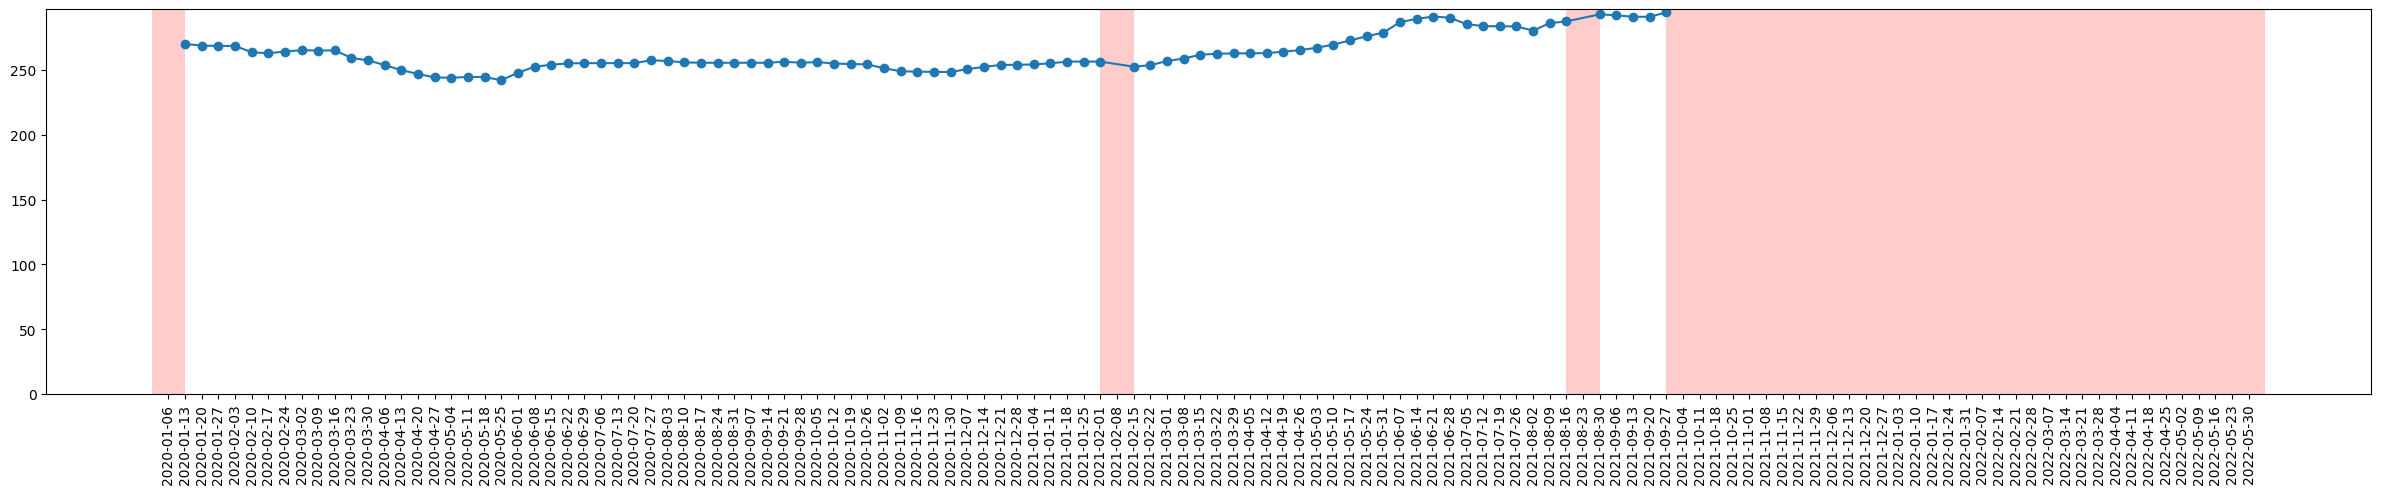

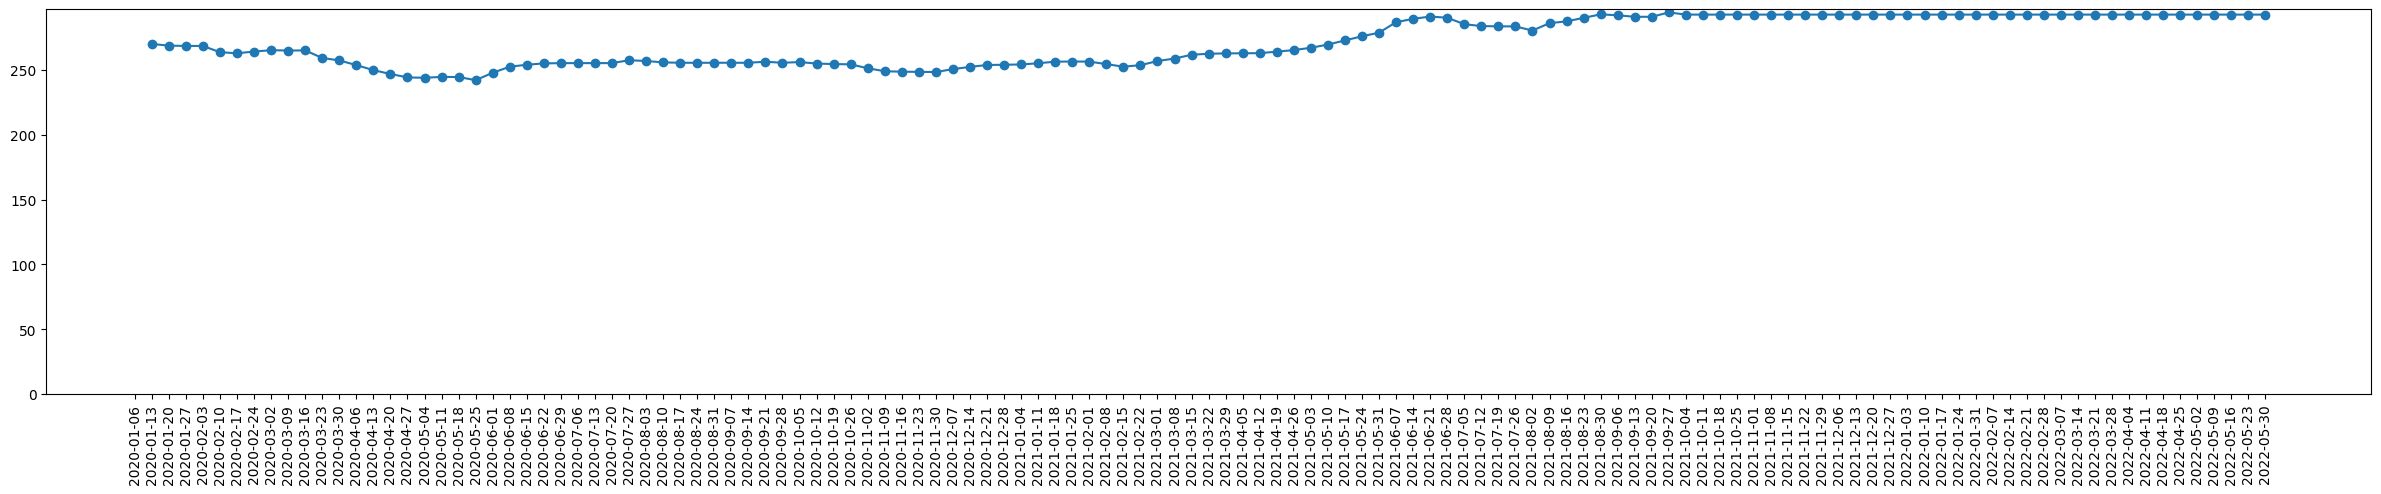

In [223]:
# step3: plot sample entry in 'df' with the largest variability

entry = 40857158
# entry = volatility_series.sort_values(ascending=False).index[0]
def plot_sample_with_ft(df_pivot, entry_id, imputed = False):
    if imputed is True:
        price_avg = 'price_avg_imputed'
    else:
        price_avg = 'price_avg'
    
    # Masking null_value
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    y = sample_entry[price_avg].astype(np.double)
    ymask = np.isfinite(y)
    
    plt.figure(figsize = (30, 5))
    plt.plot(x[ymask], y[ymask], linestyle = '-', marker = 'o')
    plt.xticks(x, rotation = 90)
    plt.ylim(bottom = 0)
    
    # axvspan with red color - find index of start & end point of null
    sample_entry = sample_entry.set_index('date')
    is_nan = sample_entry[price_avg].isna()
    n_groups = is_nan.ne(is_nan.shift()).cumsum()
    
    if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
        gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
            lambda x: (
                x.index[0] + pd.DateOffset(days=-7),
                x.index[-1] + pd.DateOffset(days=+7)
            )
        )[price_avg].values
    
        for gap in gap_list:
            plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)
    
    plt.show()

plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry, imputed = True)

# Outlier Detection

step1: define function to calculate the number of outliers & to plot the confidence bands

step2: do experiment to decide the parameter to use - size of window, sigma, etc.

step3: in last two months, count the total number of alarms by each entry

step4: suppose a price series is acquired in next time. count the total number of alarms by each entry

In [260]:
# Count the number of outliers, or plot the outliers
# Use confidence bands calculated by 'price_avg_imputed' to detect 'price_avg'
def outlier_func(df_pivot, entry_id, sigma=2, window = 4, display_plot = False, used_in_apply = False):
    
    # Plot price_avg & price_avg_imputed
    sample_entry = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = sample_entry['date']
    y = sample_entry['price_avg'].astype(np.double)
    y_imputed = sample_entry['price_avg_imputed'].astype(np.double)    
    
    # Trend_line & Confidence bands
    sample_entry['moving_avg'] = sample_entry['price_avg_imputed'].rolling(min_periods = 1, window = window).mean()
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg'].shift(1)
    sample_entry['moving_avg_shift'] = sample_entry['moving_avg_shift'].fillna(sample_entry['moving_avg'])
        
    trend_line = sample_entry['moving_avg_shift']
    
    # Standardization
    Z_y = (y - y.mean()) / y.std()
    Z_y_imputed = (y_imputed - y.mean()) / y.std()
    Z_trend_line = (trend_line - trend_line.mean()) / trend_line.std()
    upper_band = Z_trend_line + sigma
    lower_band = Z_trend_line - sigma
    
    # Outlier detection
    x_idx_lst = []
    outlier_lst = []
    
    for i in range(len(Z_y)):
        if  Z_y[i] > upper_band[i] or Z_y[i] < lower_band[i]:
            x_idx_lst.append(i)
            outlier_lst.append(y[i])
    
    outlier_date = x[x_idx_lst]
    Z_y_outlier = np.where(Z_y.index.isin(x_idx_lst), Z_y, np.nan)
    
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        plt.plot(x, Z_y, linestyle = '-', marker = 'o', color = '#5FBA09', markersize = 5)
        plt.plot(x, Z_y_imputed, linestyle = '--', marker = '^', color = '#5FBA09', alpha = 0.5, markersize = 5)
        plt.plot(x, Z_trend_line, color = '#ff9933')
        plt.plot(x, upper_band, '--', color='#ff0000')
        plt.plot(x, lower_band, '--', color='#ff0000')
        plt.plot(x, Z_y_outlier, 'o'
            , markersize = 12, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2)
        plt.xticks(x, rotation = 90)
        plt.title(f'entry_id: {entry_id}, window: {window}, sigma: {sigma}')

        # axvspan with red color - find index of start & end point of null
        sample_entry = sample_entry.set_index('date')
        is_nan = sample_entry['price_avg'].isna()
        n_groups = is_nan.ne(is_nan.shift()).cumsum()

        if len(sample_entry[is_nan].groupby(n_groups).groups) > 1:
            gap_list = sample_entry[is_nan].groupby(n_groups).aggregate(
                lambda x: (
                    x.index[0] + pd.DateOffset(days=-7),
                    x.index[-1] + pd.DateOffset(days=+7)
                )
            )['price_avg'].values

            for gap in gap_list:
                plt.axvspan(gap[0], gap[1], facecolor='r', alpha=0.2)

        plt.show()
    
    if used_in_apply is True:
        return len(outlier_lst)
    else:
        return x_idx_lst, outlier_date, outlier_lst

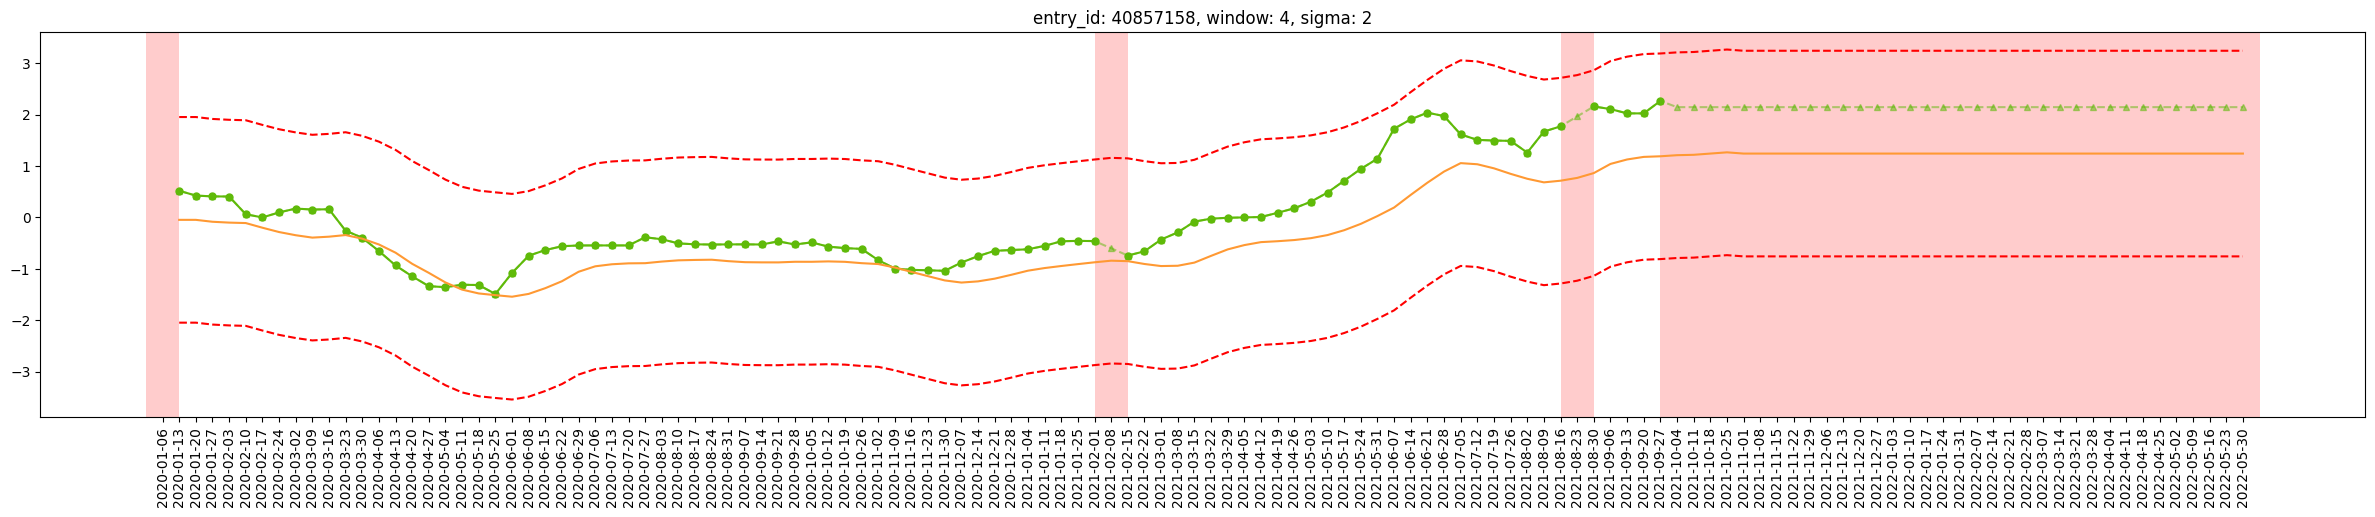

([], Series([], Name: date, dtype: datetime64[ns]), [])

In [263]:
# Plot outlier detection
outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = True)

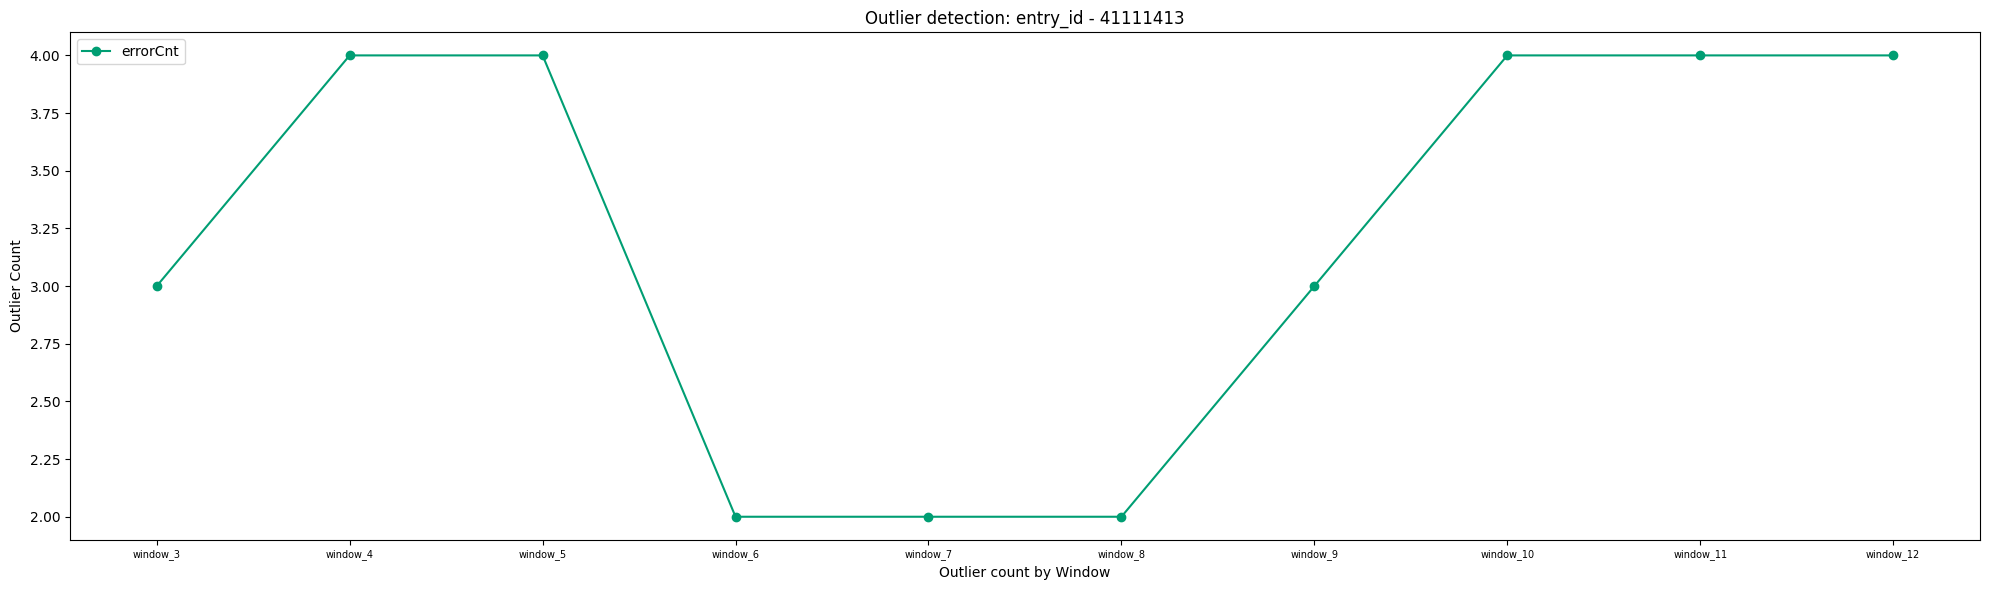

In [166]:
# Count the number of outliers, and plot the number of outliers
def errorCnt_by_window(df_pivot, entry_id, sigma = 2):
    # window from 3 to 12 - Count number of outliers
    for window in range(3, 13):
        df_pivot[f'outlier_cnt', f'window_{window}'] = df_pivot.apply(lambda row: outlier_func(df_pivot, entry_id = entry_id, sigma = sigma, window = window, used_in_apply = True), axis = 1)
    return df_pivot

def errorCnt_by_window_plot(df_pivot, entry_id):
    df_window = df_pivot['outlier_cnt'][df_pivot.index == entry_id].stack().to_frame(name = 'errorCnt')
    df_window.index.set_names(['entry_id_', 'window'], inplace = True)
    df_window = df_window.reset_index().set_index('window')
    
    plt.figure(figsize=(20, 6))
    plt.plot(df_window.index, df_window['errorCnt'], marker = 'o', linestyle = '-', color = '#009E73')
    plt.xlabel('Outlier count by Window')
    plt.xticks(rotation = 0, fontsize = 7)
    plt.ylabel('Outlier Count')
    plt.title(f'Outlier detection: entry_id - {entry_id}')
    plt.legend(['errorCnt'], loc = 'upper left')
    plt.tight_layout()

    plt.show()

df_pivot_outlierCnt = df_pivot[df_pivot.index == entry].copy()
errorCnt_by_window(df_pivot = df_pivot_outlierCnt, entry_id = entry, sigma = 2)
errorCnt_by_window_plot(df_pivot = df_pivot_outlierCnt, entry_id = entry)

  0%|                                                          | 0/10 [00:00<?, ?it/s]

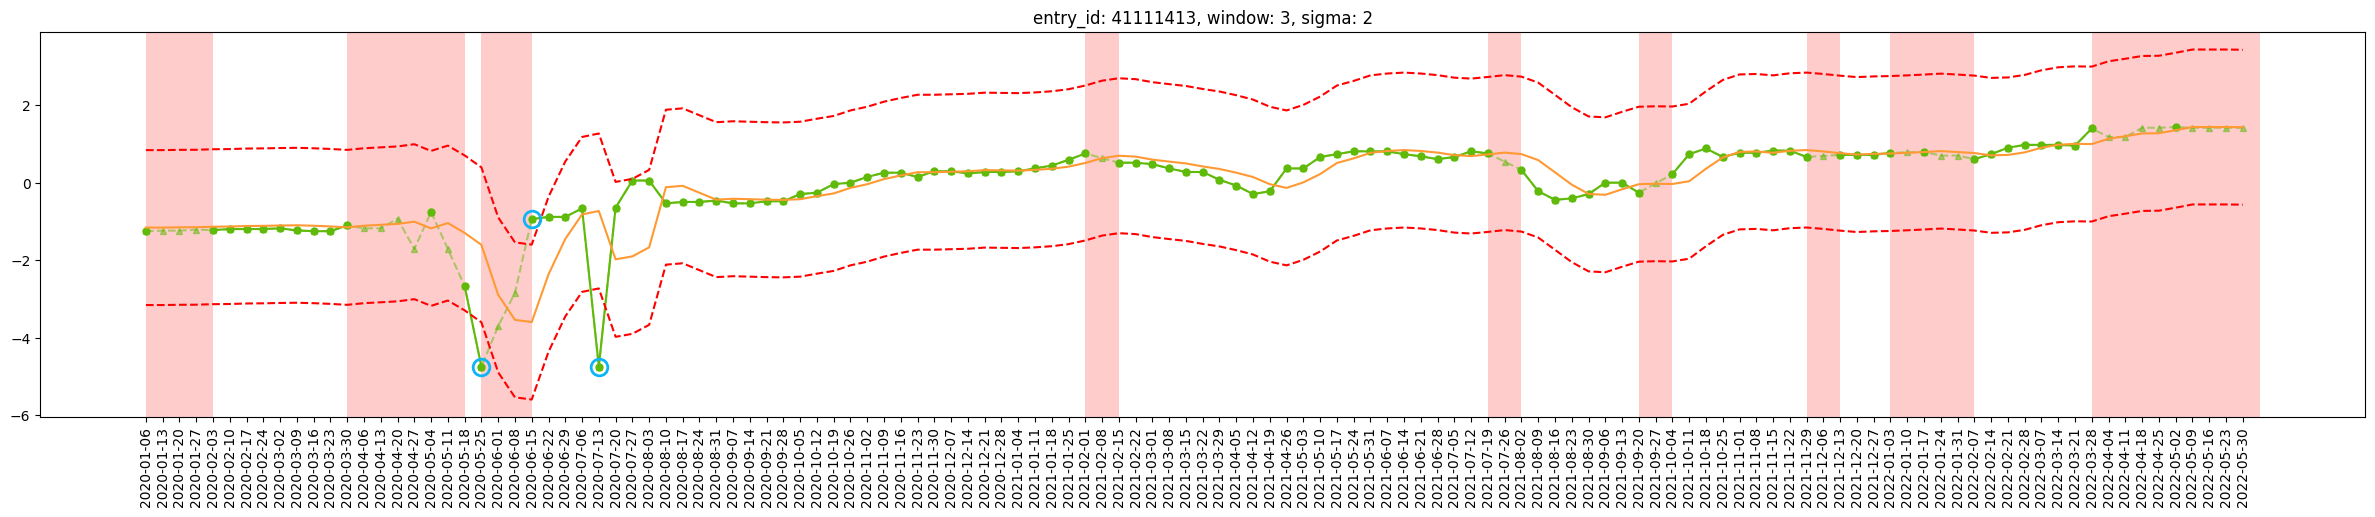

 10%|█████                                             | 1/10 [00:01<00:11,  1.32s/it]

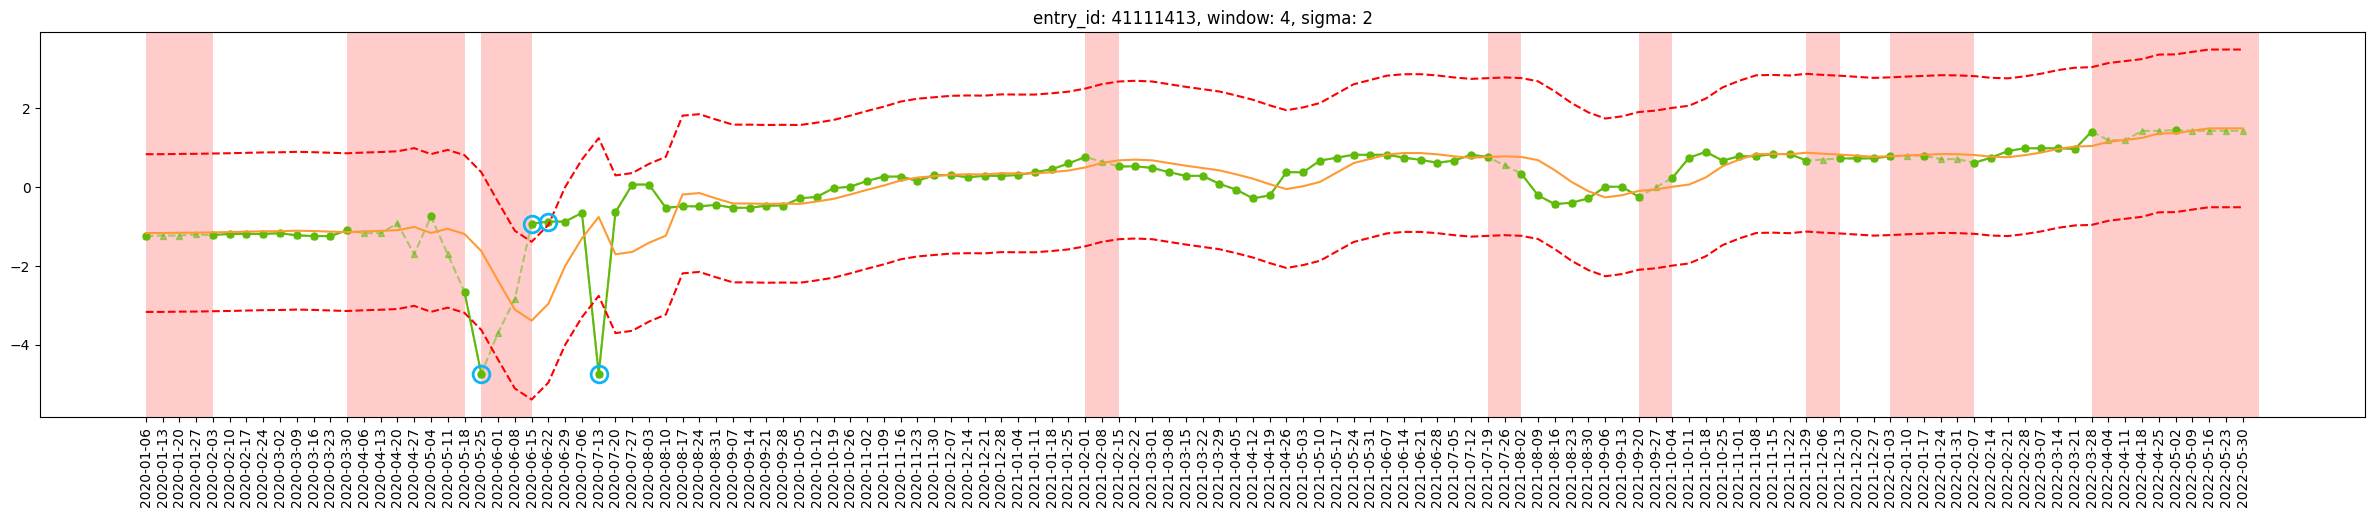

 20%|██████████                                        | 2/10 [00:02<00:11,  1.44s/it]

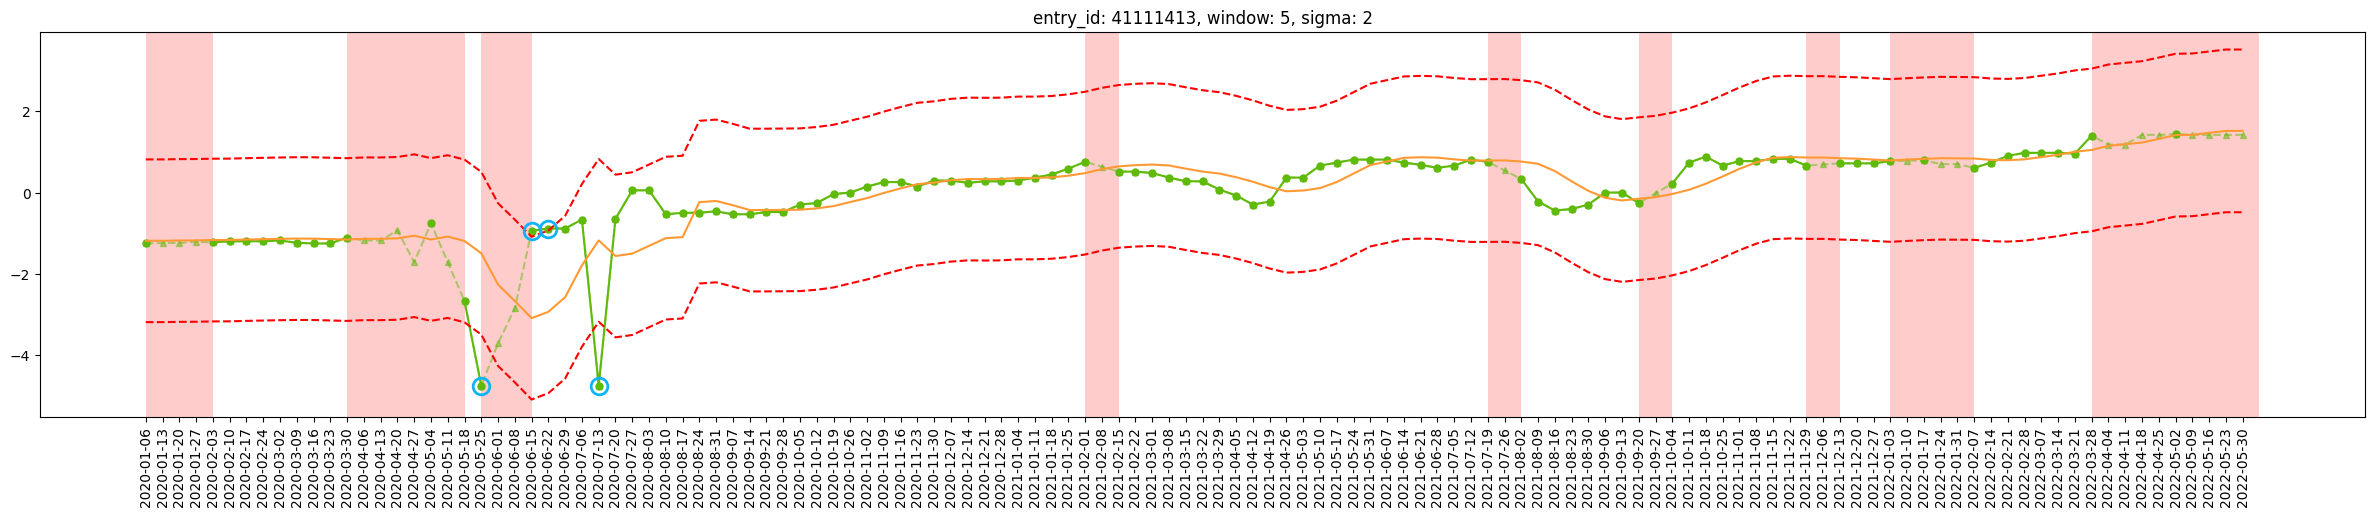

 30%|███████████████                                   | 3/10 [00:04<00:10,  1.52s/it]

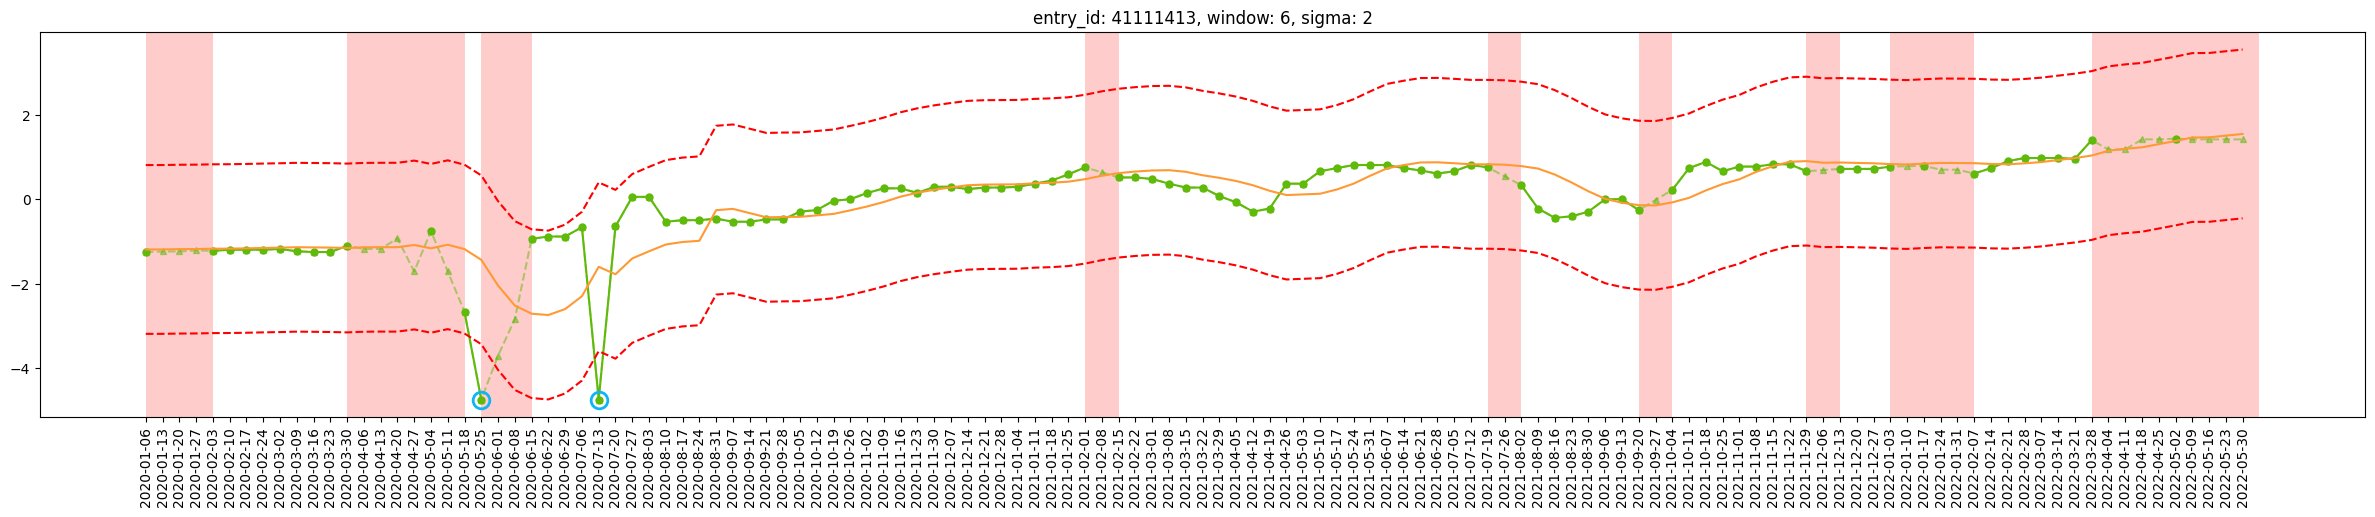

 40%|████████████████████                              | 4/10 [00:05<00:08,  1.44s/it]

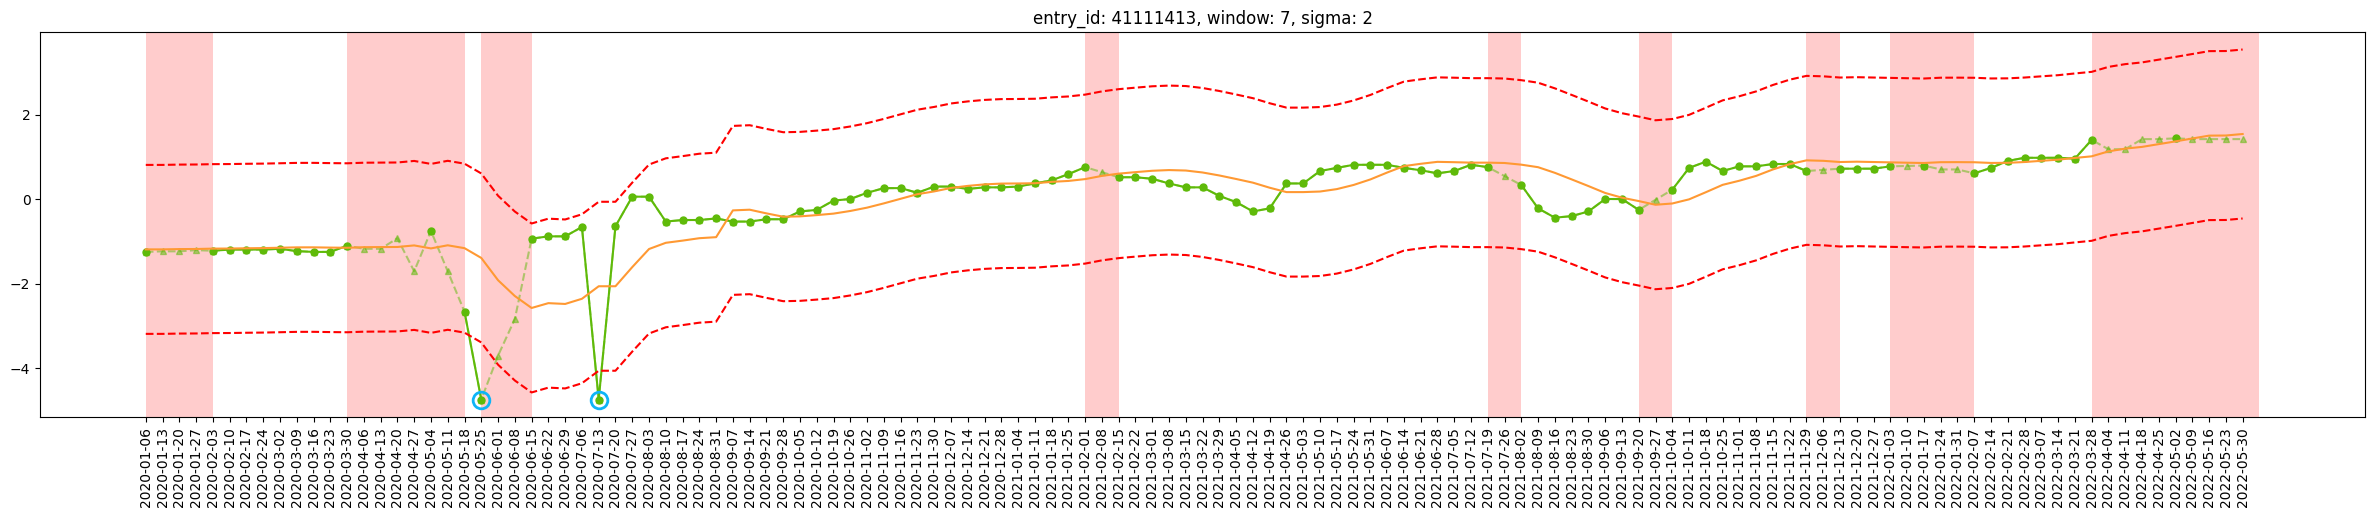

 50%|█████████████████████████                         | 5/10 [00:07<00:08,  1.66s/it]

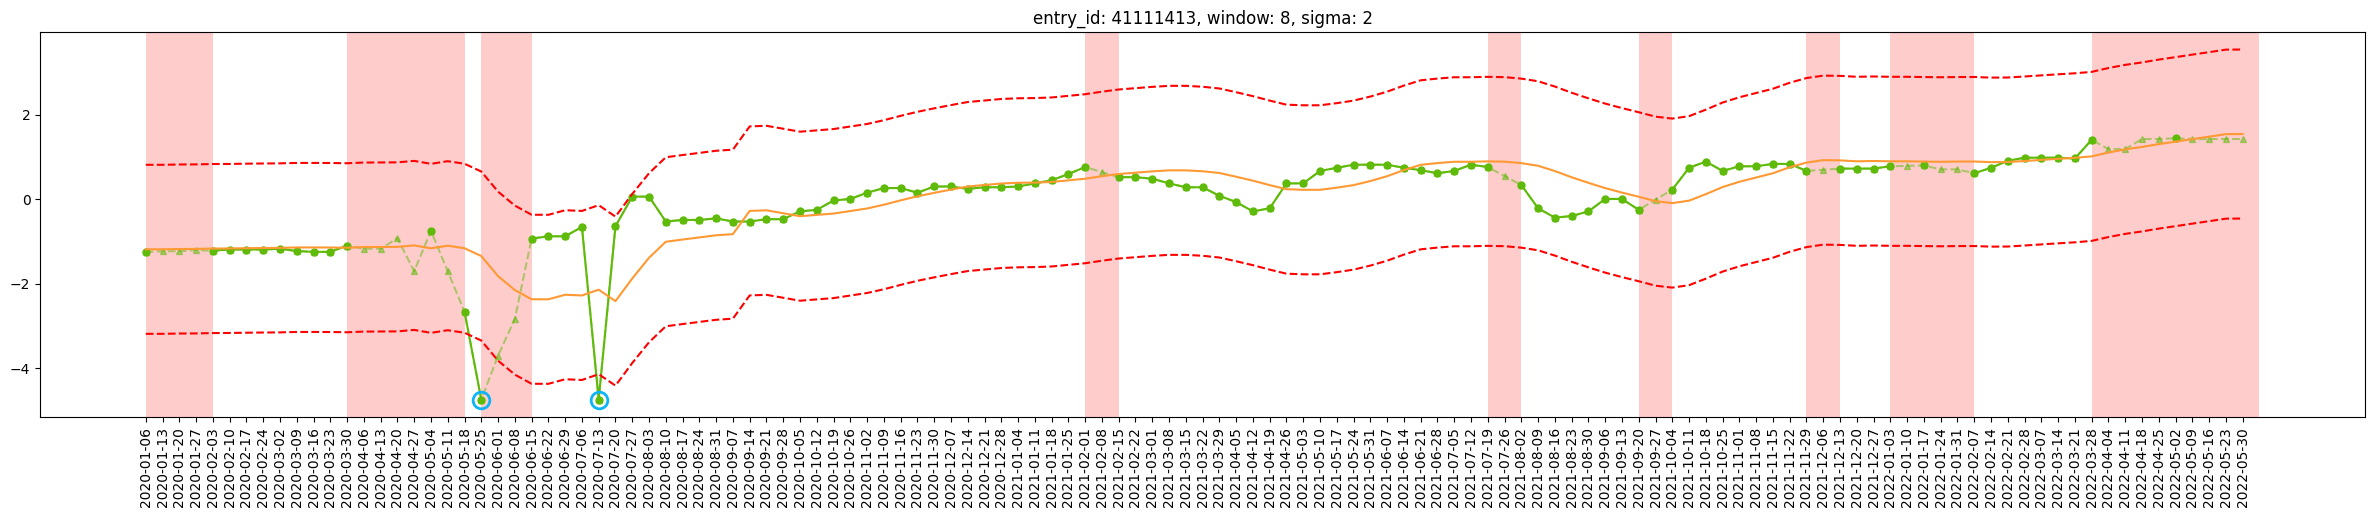

 60%|██████████████████████████████                    | 6/10 [00:09<00:06,  1.55s/it]

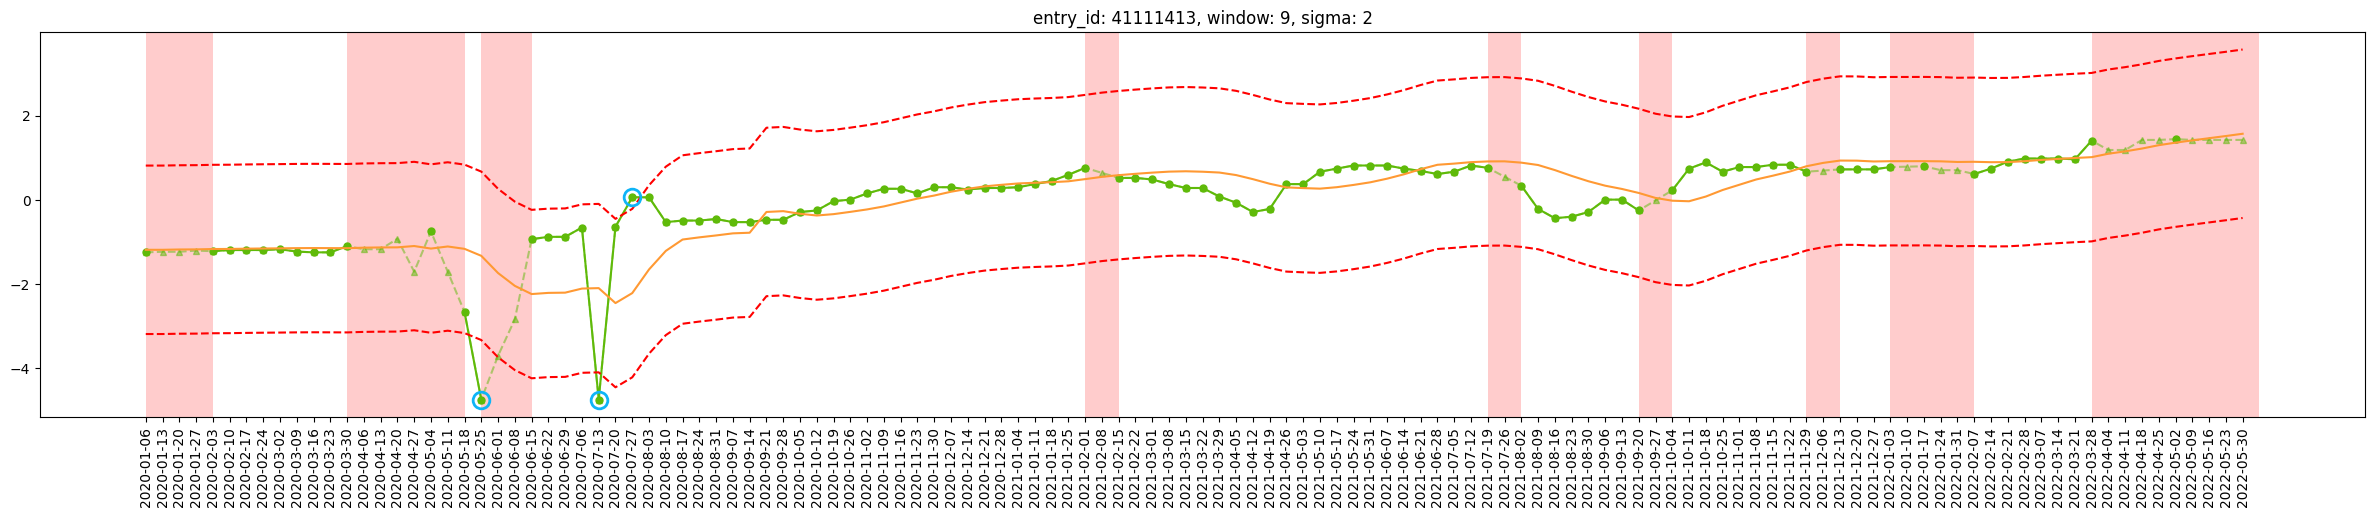

 70%|███████████████████████████████████               | 7/10 [00:10<00:04,  1.48s/it]

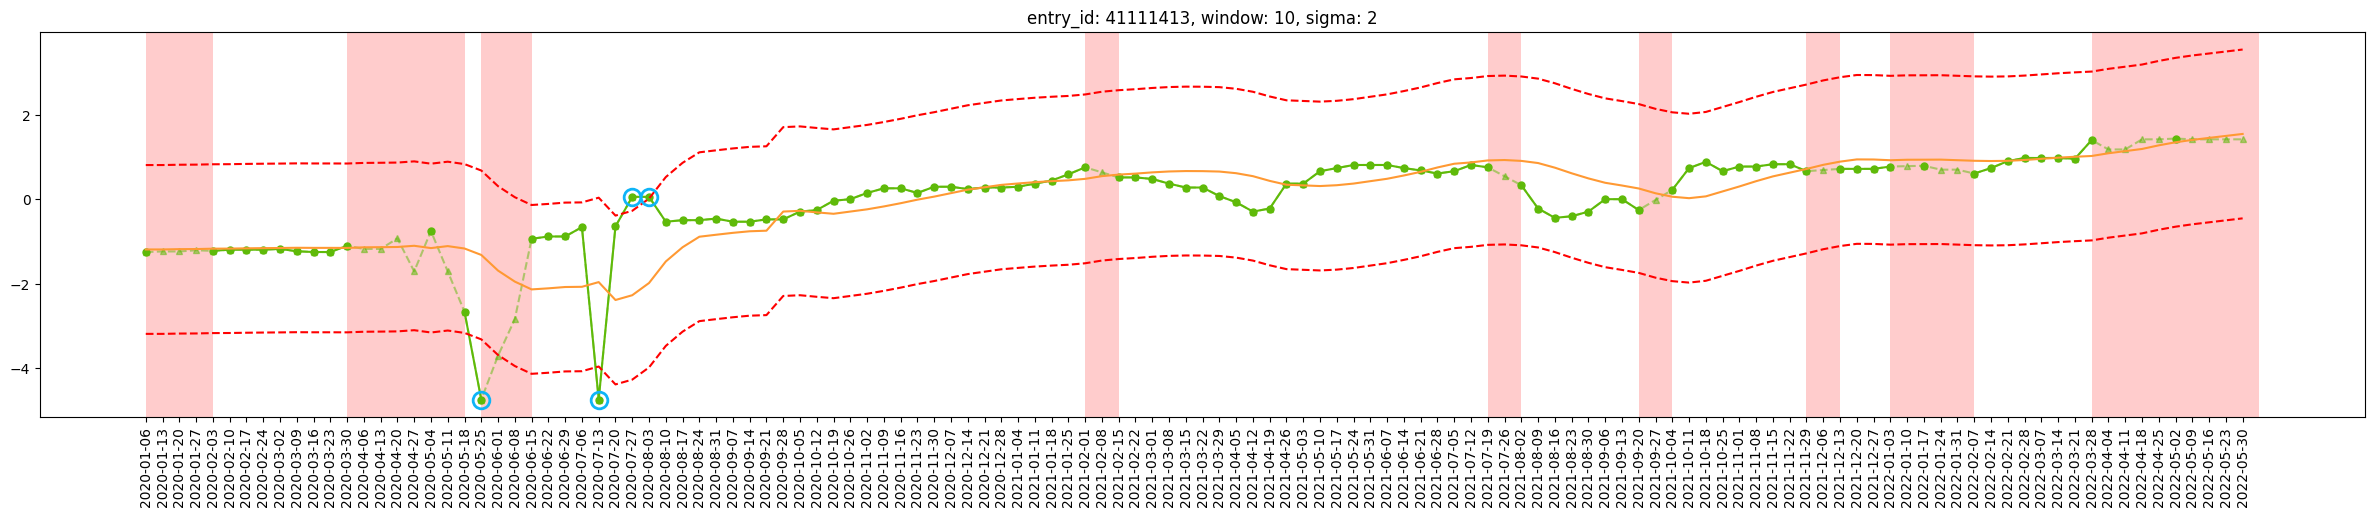

 80%|████████████████████████████████████████          | 8/10 [00:11<00:02,  1.47s/it]

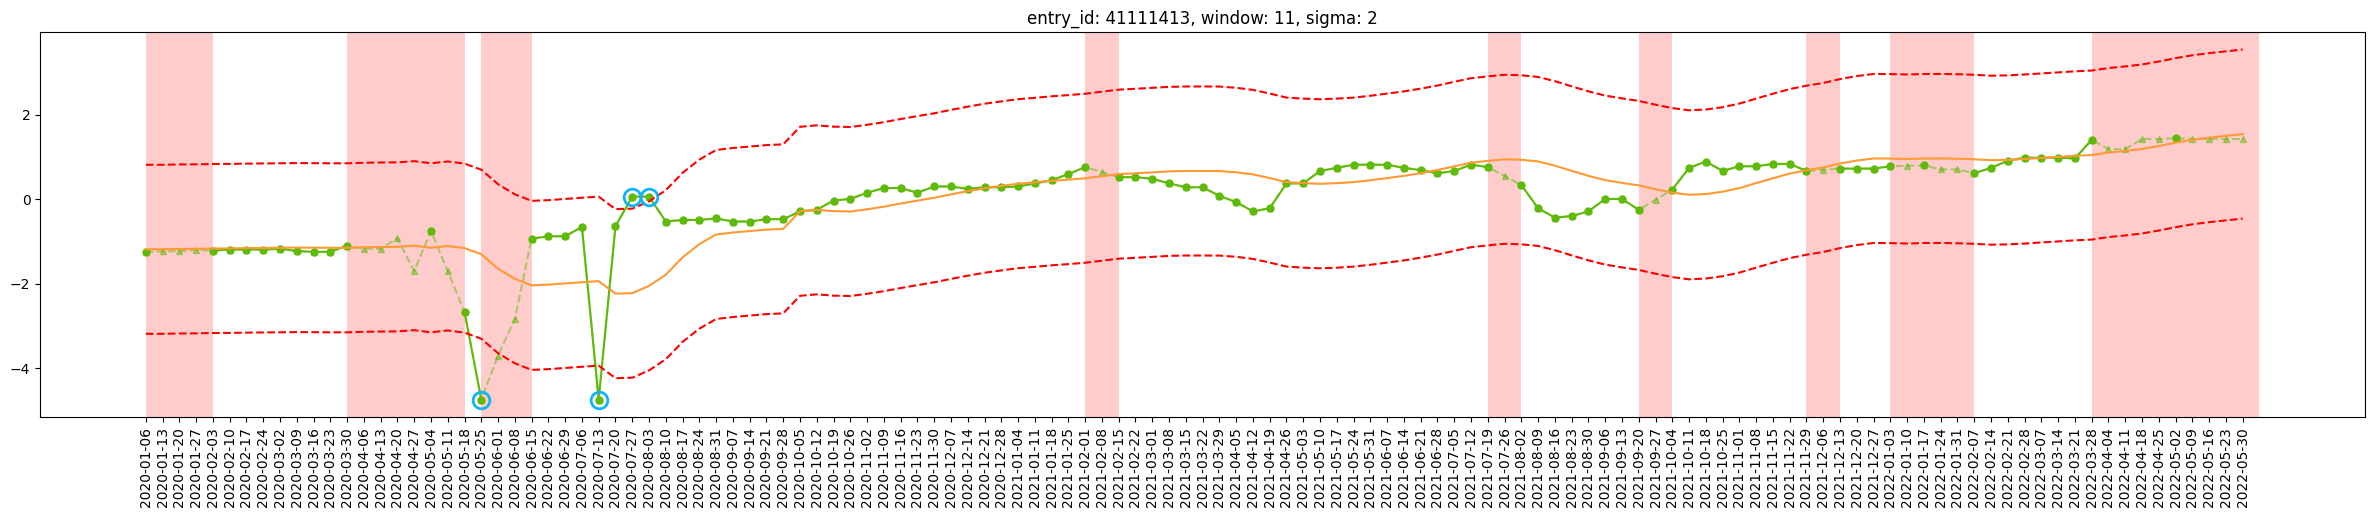

 90%|█████████████████████████████████████████████     | 9/10 [00:13<00:01,  1.42s/it]

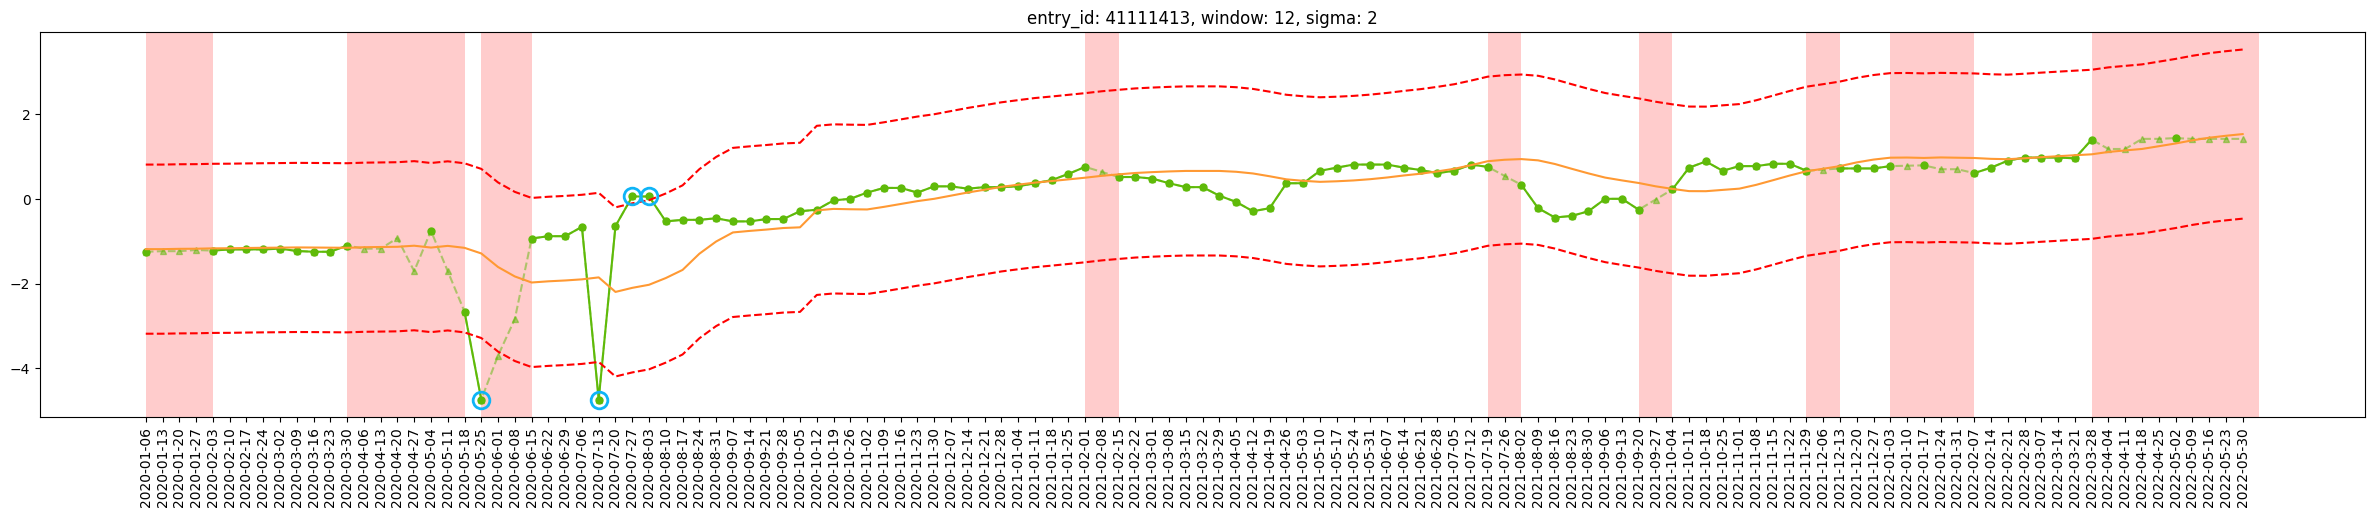

100%|█████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


In [167]:
# Plot outlier detection according to the size of window
for window in tqdm(range(3, 13)):
    outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = window, display_plot = True)

# Conclusion: Window = 4, sigma = 2
**Reason: Abnormal price would appear when:
1) External environment (e.g. bad weather, world war, shortage in supply)

2) Human mistake - mistakenly input the price data

Suppose that at a certain point (Tn-1), price changes with a huge rate, so the alarm occurs.
It could be the case because of the two reasons above.

Even though there could be some situations when price ups and downs frequently while drawing a huge amplitude, but those are rare. Generally, the changed price would maintain for a certain period of time (although there might be a slight change).

But, if we increase the window, then the detection bands would be too "flattend".
It will cause mainly two kind of problems as described below:
1) too flattened to detect the abnormalility.

2) detect again the next price ("Tn") and raise an alarm even it is plausible throughout the context. It is proved from the gragh above ("number of Outlier deteciton") that the number of alarms increase proportionally with size of the window.

# Compare new detection logic with as-is logic

In [168]:
# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
def as_is_alarm(row, display_plot = False, plot_together = False):
    # As-is alarm 1
    outlier_dic = {'alarm1': [], 'alarm2': []}
    
    alarm1_x_idx_lst = []
    for i in range(1, len(row)):
        chg_rate = (row[i] - row[i-1]) / row[i-1]
        if chg_rate > 2:
            alarm1_x_idx_lst.append(i)
            outlier_dic['alarm1'].append(row[i])  

    # As-is alarm 2
    average = row.mean()
    threshold_min = average - 2 * np.std(row)
    threshold_max = average + 2 * np.std(row)
    if threshold_min < 0:
        threshold_min = 0
    
    alarm2_x_idx_lst = []
    for idx, point in enumerate(row, start = 0):
        if point < threshold_min or point > threshold_max:
            alarm2_x_idx_lst.append(idx)
            outlier_dic['alarm2'].append(point)
    
    if display_plot is True:
        plt.figure(figsize = (20, 5))
        
        plt.plot(row, marker= 'o')
        plt.plot([0, len(row)], [average, average], '-')
        plt.plot([0, len(row)], [threshold_min, threshold_min], '--', color='#ff0000')
        plt.plot([0, len(row)], [threshold_max, threshold_max], '--', color='#ff0000')
        plt.plot(alarm1_x_idx_lst, outlier_dic['alarm1'], 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'red', markeredgewidth = 2 )
        plt.plot(alarm2_x_idx_lst, outlier_dic['alarm2'], 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'green', markeredgewidth = 2 )       
        
        if plot_together is True:
            plt.plot(new_x_idx_lst, new_outlier_lst, 'o'
                     , markersize = 20, markerfacecolor = 'None', markeredgecolor = 'black', markeredgewidth = 2 )
            
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.legend(['Price', 'Average', 'Lower bound', 'Upper bound', 'As-is Alarm1', 'As-is Alarm2', 'New Alarm'], loc = 'lower right'
                  , borderpad = 0.5, labelspacing = 1)    
        plt.tight_layout()
        
        plt.show()
    
    alarm1_set = set(outlier_dic['alarm1'])
    alarm2_set = set(outlier_dic['alarm2'])
    unioned_set = alarm1_set.union(alarm2_set)
    
    return alarm1_set, alarm2_set, unioned_set

In [264]:
new_x_idx_lst, new_outlier_date, new_outlier_lst = outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = False)

# As-is Logic VS To-be Logic - Change rate > 200 %, then raise an alarm
def as_is_alarm_(df_pivot, entry_id, display_plot = False, plot_together = False):
    entry_df = df_pivot[df_pivot.index == entry_id].stack(dropna = False).reset_index().drop(['entry_id_'], axis = 1)
    x = entry_df['date']
    price = entry_df['price_avg']
    
    # As-is alarm 1
    outlier_dic = {'alarm1': [], 'alarm2': []}
    
    alarm1_x_idx_lst = []
    for i in range(1, len(entry_df)):
        chg_rate = (price[i] - price[i-1]) / price[i-1]
        if chg_rate > 2:
            alarm1_x_idx_lst.append(i)
            outlier_dic['alarm1'].append(price[i]) 
    
    price_alarm1 = np.where(price.index.isin(alarm1_x_idx_lst), price, np.nan)

    # As-is alarm 2
    average = price.mean()
    threshold_min = average - 2 * price.std()
    threshold_max = average + 2 * price.std()
    if threshold_min < 0:
        threshold_min = 0
    
    alarm2_x_idx_lst = []
    for idx, point in enumerate(price, start = 0):
        if point < threshold_min or point > threshold_max:
            alarm2_x_idx_lst.append(idx)
            outlier_dic['alarm2'].append(point)
    
    price_alarm2 = np.where(price.index.isin(alarm2_x_idx_lst), price, np.nan)
    
    # To-be alarm
    new_price_alarm = np.where(price.index.isin(new_x_idx_lst), price, np.nan)
    
    if display_plot is True:
        plt.figure(figsize = (30, 5))
        
        plt.plot(x, price, marker= 'o')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [average, average], '-')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_min, threshold_min], '--', color='#ff0000')
        plt.plot([x.iat[0], x.iat[len(x)-1]], [threshold_max, threshold_max], '--', color='#ff0000')
        plt.plot(x, price_alarm1, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'red', markeredgewidth = 2 )
        plt.plot(x, price_alarm2, 'o'
                 , markersize = 12, markerfacecolor = 'None', markeredgecolor = 'green', markeredgewidth = 2 )       
        
        if plot_together is True:
            plt.plot(x, new_price_alarm, 'o'
                     , markersize = 20, markerfacecolor = 'None', markeredgecolor = '#0EB4F7', markeredgewidth = 2 )
        plt.xticks(x, rotation = 90)
        plt.xlabel('Time (weeks)')
        plt.ylabel('Price')
        plt.legend(['Price', 'Average', 'Lower bound', 'Upper bound', 'As-is Alarm1', 'As-is Alarm2', 'New Alarm'], loc = 'lower right'
                  , borderpad = 0.5, labelspacing = 1)    
        plt.tight_layout()
        
        plt.show()
    
    alarm1_set = set(outlier_dic['alarm1'])
    alarm2_set = set(outlier_dic['alarm2'])
    unioned_set = alarm1_set.union(alarm2_set)
    
    return alarm1_set, alarm2_set, unioned_set


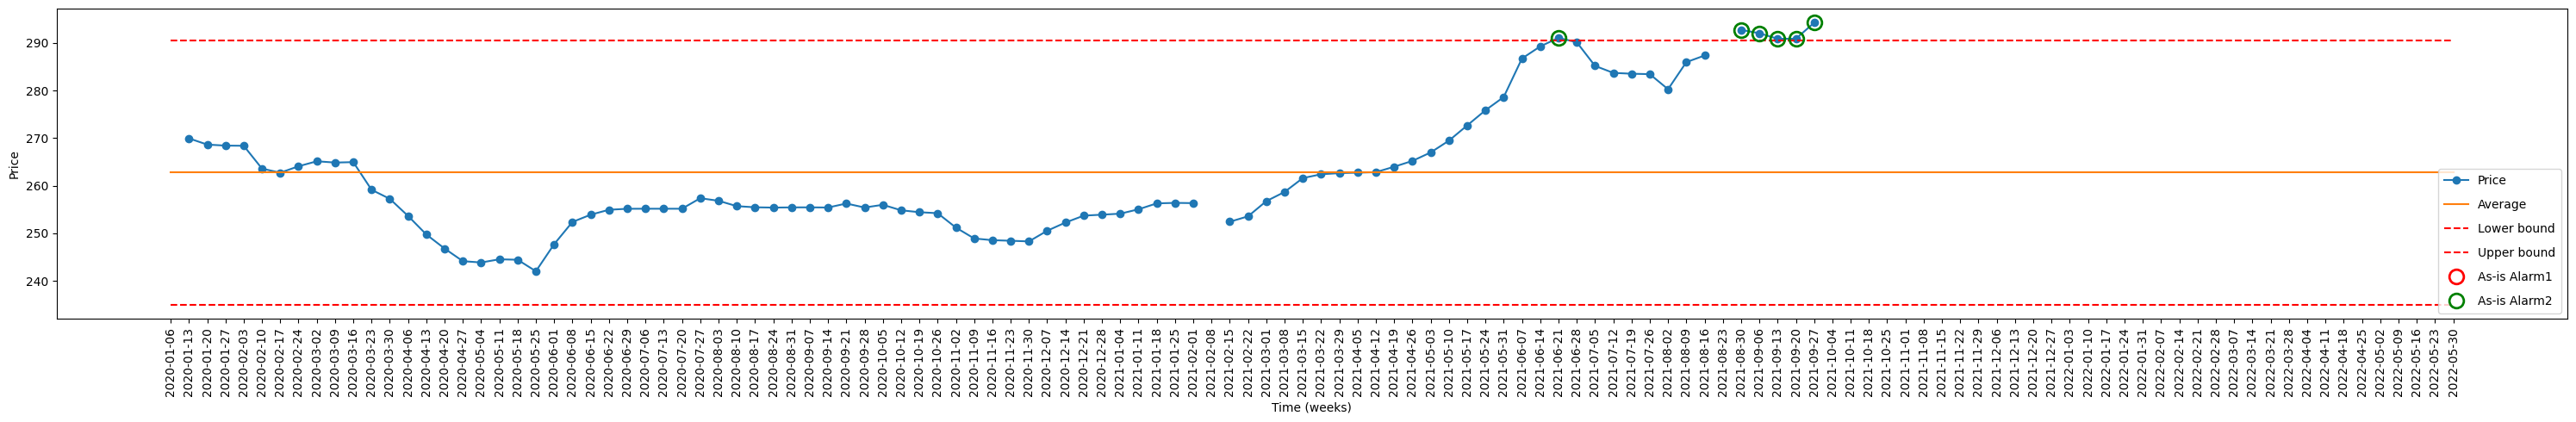

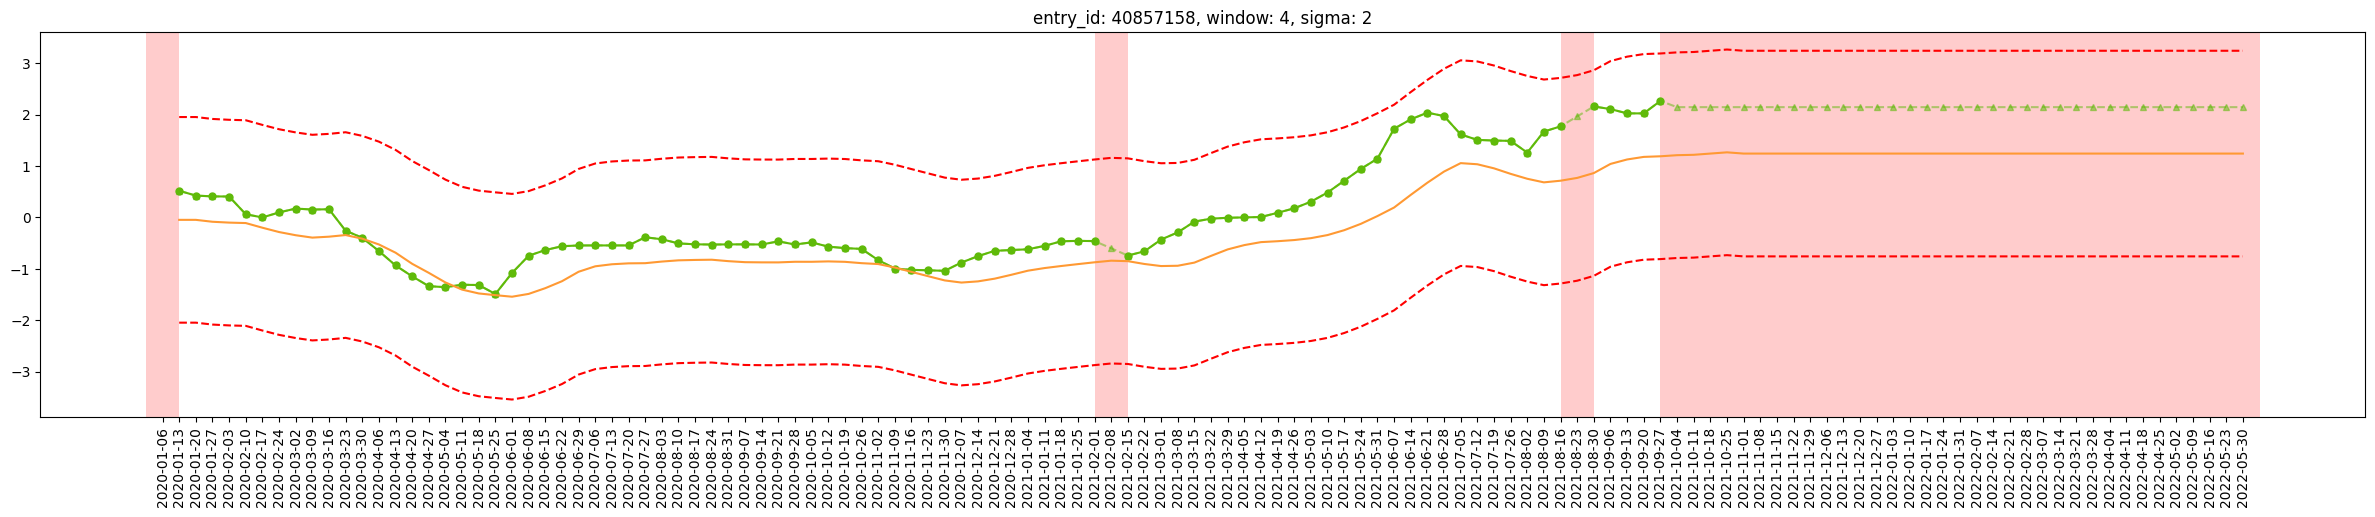

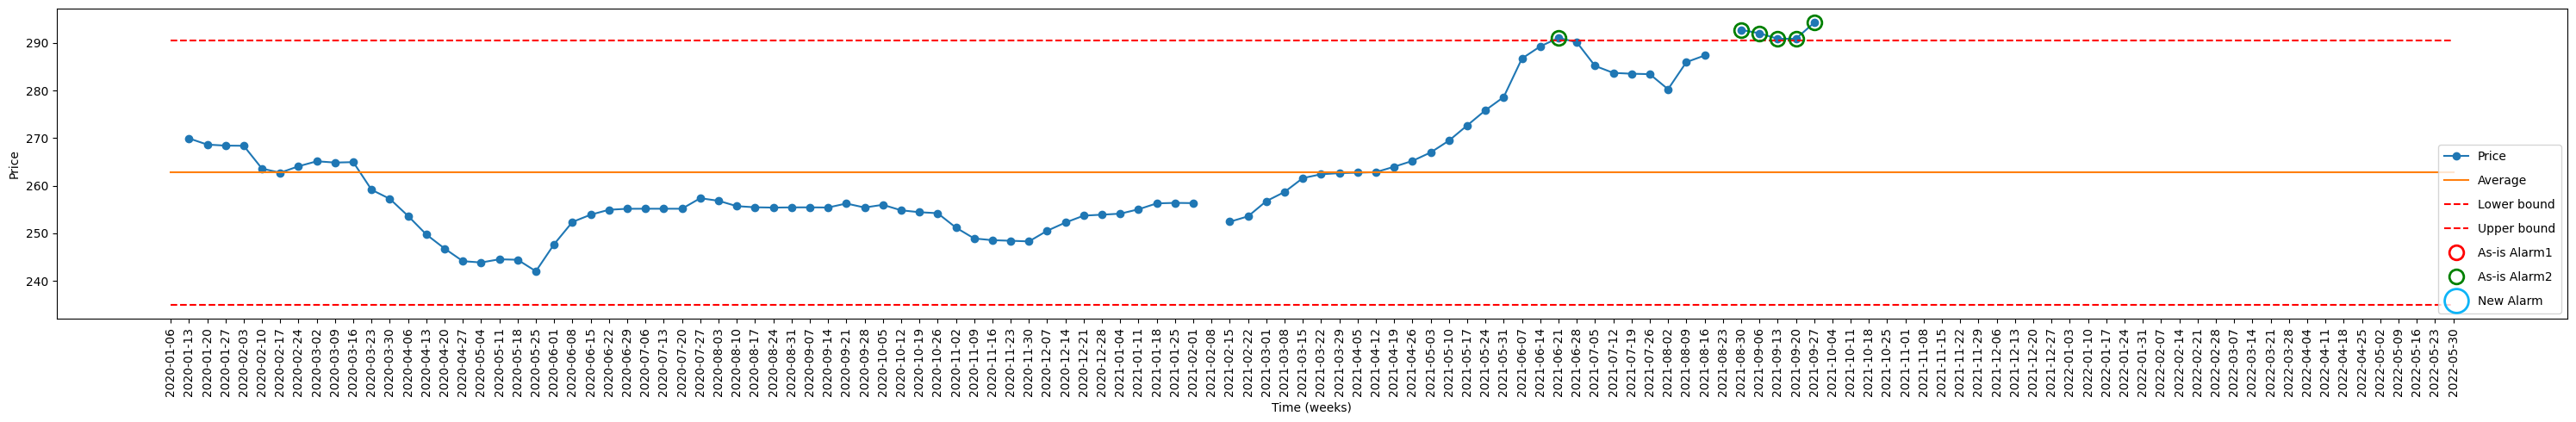

As-is alarm 1 (Alarm 1): []
As-is alarm 2 (Alarm 2): [290.9, 291.09, 292.06, 292.77, 294.27]
As-is alarm 1, 2 union: [290.9, 291.09, 292.06, 292.77, 294.27]

To-be alarm 1, 2 : []


In [265]:
# As-is Logic
alarm1_set, alarm2_set, unioned_set = as_is_alarm_(df_pivot, entry_id = entry, display_plot = True)
# To-be Logic
outlier_func(df_pivot = df_pivot, entry_id = entry, sigma = 2, window = 4, display_plot = True)
# Together
as_is_alarm_(df_pivot, entry_id = entry, display_plot = True, plot_together = True)
print(f'As-is alarm 1 (Alarm 1): {sorted(alarm1_set)}')
print(f'As-is alarm 2 (Alarm 2): {sorted(alarm2_set)}')
print(f'As-is alarm 1, 2 union: {sorted(unioned_set)}')
print()
print(f'To-be alarm 1, 2 : {sorted(new_outlier_lst)}')

# Result

In [171]:
df_ = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()

In [172]:
def Raize_as_is_alarm(price_avg):    
#     for i in range(1, len(price_avg)):
        
#         chg_rate = (price_av[i] - price_avg[i-1]) / price_avg[i-1]
#         if chg_rate > 2:
#             alarm1_x_idx_lst.append(i)
#             outlier_dic['alarm1'].append(price[i]) 
    y = price_avg.astype(np.double)    
    avg = y.mean()
    threshold_min = avg - 2 * y.std()
    threshold_max = avg + 2 * y.std()
    if threshold_min < 0:
        threshold_min = 0

    df_y = y.to_frame(name = 'price')
    df_y['Alarm_as_is'] = np.where((y > threshold_max) | (y < threshold_min), 1, 0)
    
    Alarm_series = df_y['Alarm_as_is']
    return Alarm_series

def Raize_alarm(price_avg, price_avg_imputed):
    y = price_avg.astype(np.double)
    y_imputed = price_avg_imputed.astype(np.double)
    
    # Trend_line & Confidence bands
    moving_avg = y_imputed.rolling(min_periods = 1, window = window).mean()
    moving_avg_shift = moving_avg.shift(1)
    moving_avg_shift = moving_avg_shift.fillna(moving_avg)
    trend_line = moving_avg_shift
    
    # Standardization
    Z_y = (y - y.mean()) / y.std()
    Z_y_imputed = (y_imputed - y.mean()) / y.std()
    Z_trend_line = (trend_line - trend_line.mean()) / trend_line.std()
    upper_band = Z_trend_line + 2
    lower_band = Z_trend_line - 2

    df_y = Z_y.to_frame(name = 'Standardized_price')
    df_y['Alarm'] = np.where((Z_y > upper_band) | (Z_y < lower_band), 1, 0)
    
    Alarm_series = df_y['Alarm']
    return Alarm_series

Alarm_as_is_series = df_.groupby('entry_id_').progress_apply(lambda row : Raize_as_is_alarm(row.price_avg))
Alarm_as_is_df = Alarm_as_is_series.to_frame().reset_index(drop = True)
df_ = pd.concat([df_, Alarm_as_is_df], axis = 1)

Alarm_series = df_.groupby('entry_id_').progress_apply(lambda row : Raize_alarm(row.price_avg, row.price_avg_imputed))
Alarm_df = Alarm_series.to_frame().reset_index(drop = True)
df_ = pd.concat([df_, Alarm_df], axis = 1)

100%|████████████████████████████████████████████| 2984/2984 [00:09<00:00, 302.67it/s]


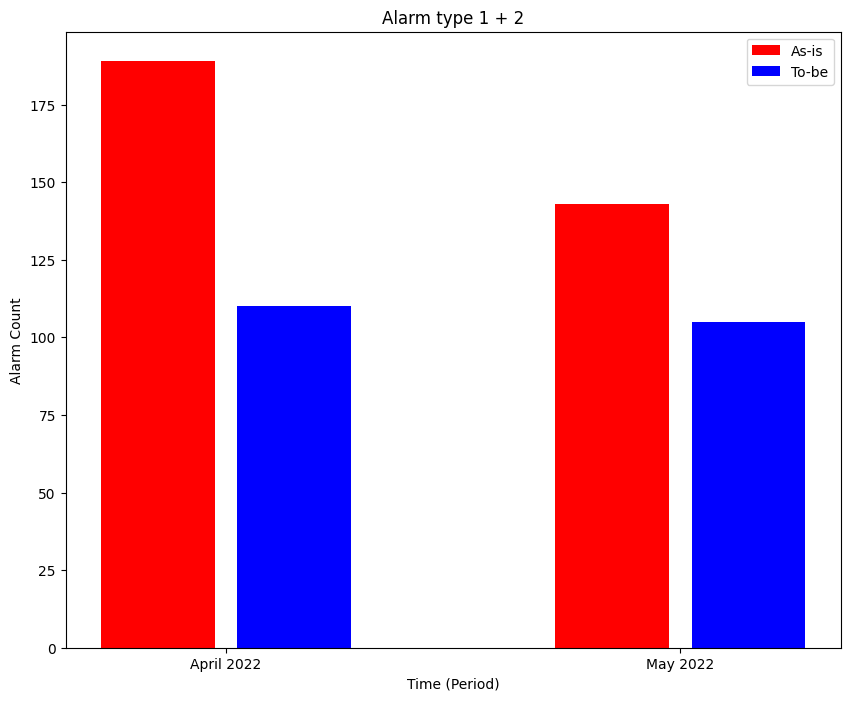

In [184]:
result_april_as_is = df_[(
    df_['date'] > pd.Timestamp('2022-04-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-01')) & (
    df_['Alarm_as_is'] == 1)].groupby('entry_id_')['Alarm_as_is'].sum()

result_april = df_[(
    df_['date'] > pd.Timestamp('2022-04-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-01')) & (
    df_['Alarm'] == 1)].groupby('entry_id_')['Alarm'].sum()

result_may_as_is = df_[(
    df_['date'] > pd.Timestamp('2022-05-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-31')) & (
    df_['Alarm_as_is'] == 1)].groupby('entry_id_')['Alarm_as_is'].sum()

result_may = df_[(
    df_['date'] > pd.Timestamp('2022-05-01')) & (
    df_['date'] <= pd.Timestamp('2022-05-31')) & (
    df_['Alarm'] == 1)].groupby('entry_id_')['Alarm'].sum()

x = np.arange(2)
period = ['April 2022', 'May 2022']
asis = [result_april_as_is.sum(), result_may_as_is.sum()]
tobe = [result_april.sum(), result_may.sum()]

plt.figure(figsize = (10,8))
plt.bar(x, asis, color = 'red', width = 0.25, label = 'As-is')
plt.bar(x+0.3, tobe, color = 'blue', width = 0.25, label = 'To-be')
plt.xticks(x+0.15, period)
plt.legend()
plt.xlabel('Time (Period)')
plt.ylabel('Alarm Count')
plt.title('Alarm type 1 + 2')
plt.show()

# Implementation

In [252]:
df_stats = df[['date', 'entry_id_', 'price_avg', 'price_avg_imputed']].copy()
df_stats_pivot = df_stats.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)

In [253]:
def Calculate_Trend(df):
    df['moving_avg'] = df.groupby('entry_id_')['price_avg_imputed'].rolling(window = 4, min_periods = 1).mean().reset_index(0, drop=True)
    df['moving_avg_shift'] = df.groupby('entry_id_')['moving_avg'].shift(1)
    df['moving_avg_shift'] = df['moving_avg_shift'].fillna(df['moving_avg'])
    
    df['Z_price'] = (df['price_avg'] - df['price_avg'].mean()) / df['price_avg'].std()
    df['Z_moving_avg'] = (df['moving_avg_shift'] - df['moving_avg_shift'].mean()) / df['moving_avg_shift'].std()
    df['Z_upper_band'] = df['Z_moving_avg'] + 2
    df['Z_lower_band'] = df['Z_moving_avg'] - 2
    
    df['Alarm'] = np.where((
        df['Z_price'] > df['Z_upper_band']) | (
        df['Z_price'] < df['Z_lower_band'])
        , 1, 0) 
    return df

Calculate_Trend(df_stats)

,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm
0,2020-01-13,40857158,269.960000,269.960000,269.960000,269.960000,-0.192222,-0.130252,1.869748,-2.130252,0
1,2020-01-20,40857158,268.657143,268.657143,269.308571,269.960000,-0.192321,-0.130252,1.869748,-2.130252,0
2,2020-01-27,40857158,268.440000,268.440000,269.019048,269.308571,-0.192337,-0.130309,1.869691,-2.130309,0
3,2020-02-03,40857158,268.404286,268.404286,268.865357,269.019048,-0.192340,-0.130334,1.869666,-2.130334,0
4,2020-02-10,40857158,263.604286,263.604286,267.276429,268.865357,-0.192706,-0.130347,1.869653,-2.130347,0
...,...,...,...,...,...,...,...,...,...,...,...
256670,2022-05-30,134082497,NaN,3.650000,3.650000,3.650000,NaN,-0.153472,1.846528,-2.153472,0
256671,2022-05-23,134131642,1100.000000,1100.000000,1100.000000,1100.000000,-0.129005,-0.057879,1.942121,-2.057879,0
256672,2022-05-30,134131642,NaN,1100.000000,1100.000000,1100.000000,NaN,-0.057879,1.942121,-2.057879,0
256673,2022-05-23,134278888,44.000000,44.000000,44.000000,44.000000,-0.209431,-0.149954,1.850046,-2.149954,0


# Do Test 

- Suppose at "2022-06-05", new data is added

- Raise Alarm with 'df_stats_test' table

In [254]:
insert_df = df_stats[df_stats.date == pd.Timestamp('2022-04-04')].copy()
insert_df['date'] = pd.Timestamp('2022-06-05')
insert_df = insert_df.reset_index(drop=True).iloc[:, :4]

df_stats_test = df_stats.append(insert_df).sort_values(by = ['entry_id_', 'date']).reset_index(drop=True).copy()
df_stats_test_pivot = df_stats_test.pivot_table(['price_avg', 'price_avg_imputed']
                          , index = ['entry_id_'], columns = ['date']
                          , dropna = False)
Calculate_Trend(df_stats_test)

,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm
0,2020-01-13,40857158,269.960000,269.960000,269.960000,269.960000,-0.192225,-0.129732,1.870268,-2.129732,0
1,2020-01-20,40857158,268.657143,268.657143,269.308571,269.960000,-0.192325,-0.129732,1.870268,-2.129732,0
2,2020-01-27,40857158,268.440000,268.440000,269.019048,269.308571,-0.192341,-0.129788,1.870212,-2.129788,0
3,2020-02-03,40857158,268.404286,268.404286,268.865357,269.019048,-0.192344,-0.129813,1.870187,-2.129813,0
4,2020-02-10,40857158,263.604286,263.604286,267.276429,268.865357,-0.192709,-0.129827,1.870173,-2.129827,0
...,...,...,...,...,...,...,...,...,...,...,...
259594,2022-05-30,134082497,NaN,3.650000,3.650000,3.650000,NaN,-0.152815,1.847185,-2.152815,0
259595,2022-05-23,134131642,1100.000000,1100.000000,1100.000000,1100.000000,-0.129065,-0.057786,1.942214,-2.057786,0
259596,2022-05-30,134131642,NaN,1100.000000,1100.000000,1100.000000,NaN,-0.057786,1.942214,-2.057786,0
259597,2022-05-23,134278888,44.000000,44.000000,44.000000,44.000000,-0.209419,-0.149318,1.850682,-2.149318,0


In [255]:
df_stats[(df_stats_test['date'] == pd.Timestamp('2022-06-05')) & (df_stats_test['Alarm'] == 1)]

,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm
16066,2020-01-06,40876199,6009.666667,6009.666667,6009.666667,6009.666667,0.244919,0.370207,2.370207,-1.629793,0
66488,2020-07-06,40956245,28.340000,28.340000,27.279250,27.196250,-0.210624,-0.151419,1.848581,-2.151419,0


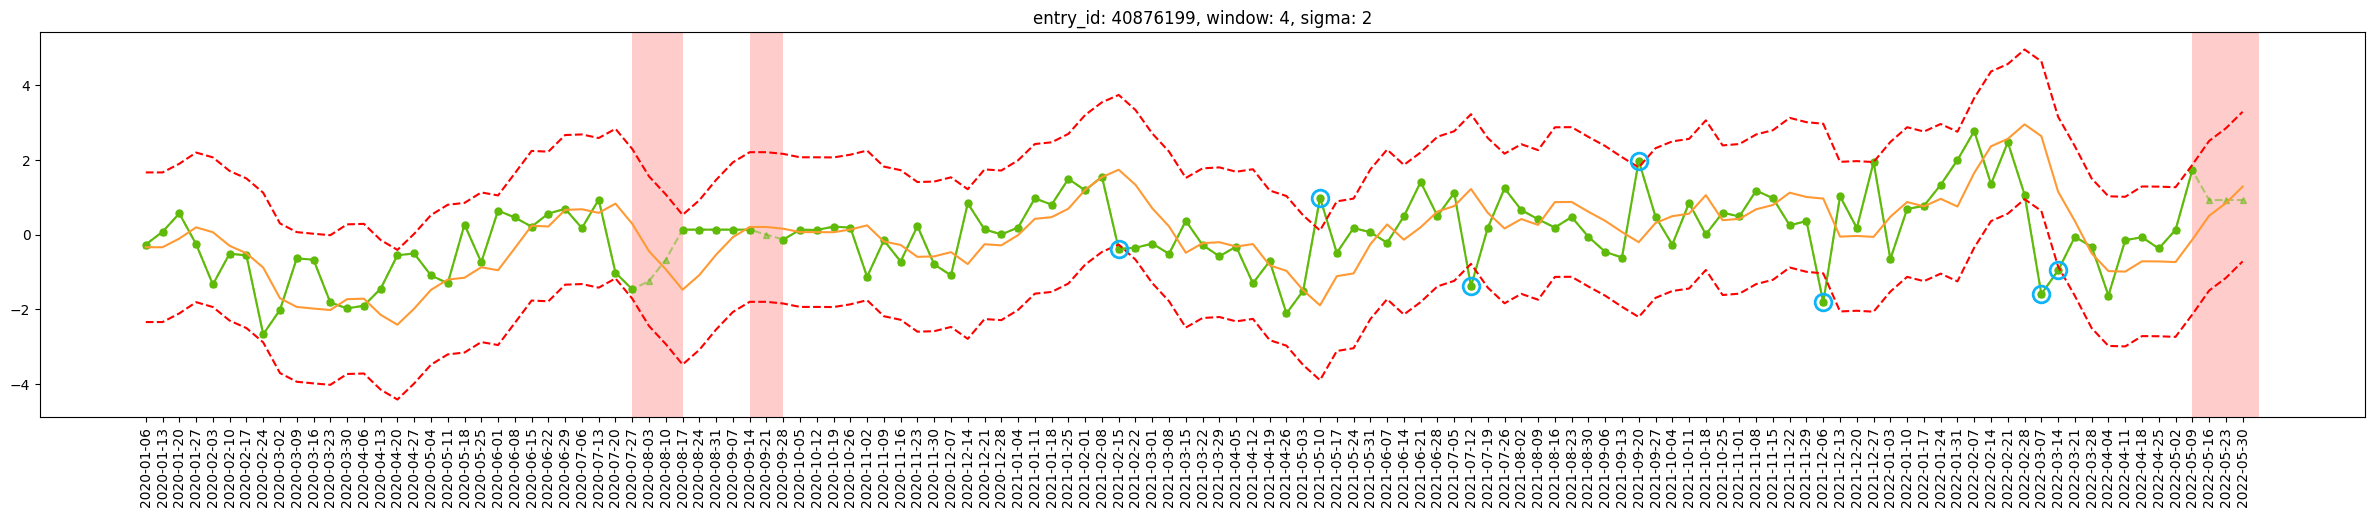

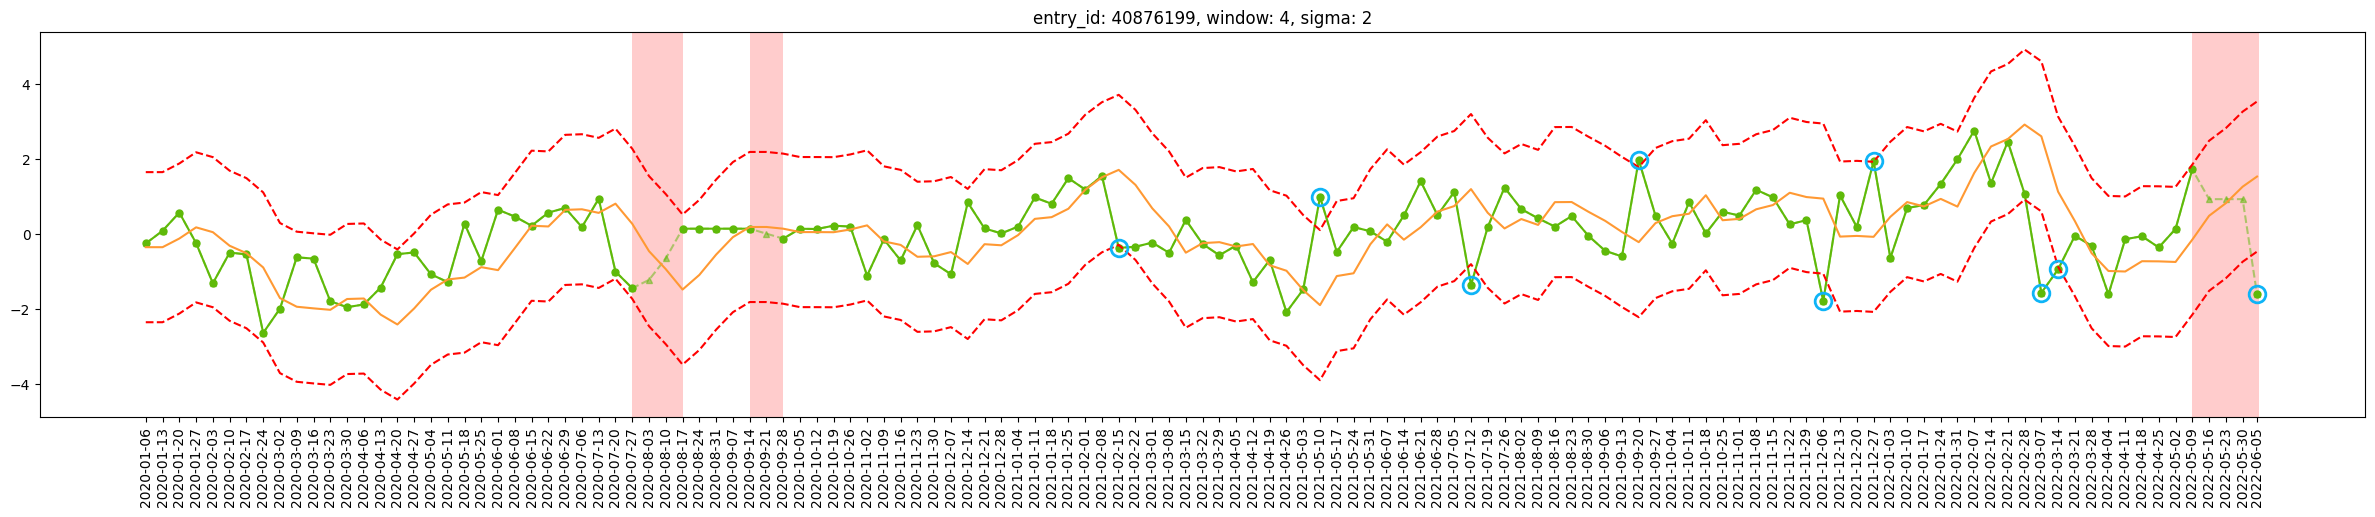

([58, 70, 79, 89, 100, 103, 113, 114, 126],
 58    2021-02-15
 70    2021-05-10
 79    2021-07-12
 89    2021-09-20
 100   2021-12-06
 103   2021-12-27
 113   2022-03-07
 114   2022-03-14
 126   2022-06-05
 Name: date, dtype: datetime64[ns],
 [5785.3333333333,
  8404.0,
  3873.6666666667,
  10300.0,
  3049.0,
  10233.0,
  3469.6,
  4678.8333333333,
  3392.6666666667])

In [266]:
outlier_func(df_pivot = df_stats_pivot, entry_id = 40876199, sigma = 2, window = 4, display_plot = True)
outlier_func(df_pivot = df_stats_test_pivot, entry_id = 40876199, sigma = 2, window = 4, display_plot = True)

# Replace historical data that is out of the orbit

- To reduce the False Alarm as much as possible

- Find the historical outlier (price_avg), and replace this one as np.nan

- Then, impute with knn, and replace the original price_avg_imputed to new price_avg_imputed

- Finally, re-plot moving_average

In [267]:
x_idx, date, outlier_lst = outlier_func(df_pivot = df_stats_pivot, entry_id = 40876199, sigma = 2, window = 4)
date

58    2021-02-15
70    2021-05-10
79    2021-07-12
89    2021-09-20
100   2021-12-06
113   2022-03-07
114   2022-03-14
Name: date, dtype: datetime64[ns]

In [274]:
# Replace Value to np.nan
df_stats.loc[(df_stats['entry_id_'] == 40876199) & (df_stats['date'].isin(date)), 'price_avg'] = np.nan

,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm
16066,2020-01-06,40876199,6009.666667,6009.666667,6009.666667,6009.666667,0.244919,0.370207,2.370207,-1.629793,0
16067,2020-01-13,40876199,6662.000000,6662.000000,6335.833333,6009.666667,0.294601,0.370207,2.370207,-1.629793,0
16068,2020-01-20,40876199,7601.400000,7601.400000,6757.688889,6335.833333,0.366147,0.398646,2.398646,-1.601354,0
16069,2020-01-27,40876199,6027.000000,6027.000000,6575.016667,6757.688889,0.246239,0.435429,2.435429,-1.564571,0
16070,2020-02-03,40876199,3962.500000,3962.500000,6063.225000,6575.016667,0.089005,0.419501,2.419501,-1.580499,0
...,...,...,...,...,...,...,...,...,...,...,...
16187,2022-05-02,40876199,6758.666667,6758.666667,6294.425000,5452.925000,0.301964,0.321663,2.321663,-1.678337,0
16188,2022-05-09,40876199,9821.200000,9821.200000,7192.350000,6294.425000,0.535209,0.395036,2.395036,-1.604964,0
16189,2022-05-16,40876199,NaN,8289.933333,7669.033333,7192.350000,NaN,0.473328,2.473328,-1.526672,0
16190,2022-05-23,40876199,NaN,8289.933333,8289.933333,7669.033333,NaN,0.514891,2.514891,-1.485109,0


In [277]:
# Step1: Change 'date' to categorical data and convert to numerical data
df_stats['date_category'] = df_stats['date'].astype('category').cat.codes

# Step2: KNNImpute
imputer_ = KNNImputer(n_neighbors = 2)
def knn_impute_price(date_series, price_series):
    before_imputation = pd.DataFrame({'date':date_series, 'price_avg':price_series})
    imputed = imputer_.fit_transform(before_imputation)
    imputed_price_series = imputed[:, 1]
    return imputed_price_series
imputed_price_series = df_stats.groupby(by = 'entry_id_').progress_apply(
                        lambda df_stats : knn_impute_price(df_stats.date_category, df_stats.price_avg)
                      )
imputed_price_series = pd.Series(np.concatenate(imputed_price_series.values), name = 'price_avg_imputed')
df_stats['price_avg_imputed'] = imputed_price_series

100%|████████████████████████████████████████████| 2984/2984 [00:11<00:00, 251.22it/s]


In [280]:
Calculate_Trend(df_stats)

,date,entry_id_,price_avg,price_avg_imputed,moving_avg,moving_avg_shift,Z_price,Z_moving_avg,Z_upper_band,Z_lower_band,Alarm,date_category
0,2020-01-13,40857158,269.960000,269.960000,269.960000,269.960000,-0.192195,-0.130256,1.869744,-2.130256,0,1
1,2020-01-20,40857158,268.657143,268.657143,269.308571,269.960000,-0.192294,-0.130256,1.869744,-2.130256,0,2
2,2020-01-27,40857158,268.440000,268.440000,269.019048,269.308571,-0.192310,-0.130313,1.869687,-2.130313,0,3
3,2020-02-03,40857158,268.404286,268.404286,268.865357,269.019048,-0.192313,-0.130338,1.869662,-2.130338,0,4
4,2020-02-10,40857158,263.604286,263.604286,267.276429,268.865357,-0.192679,-0.130351,1.869649,-2.130351,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
256670,2022-05-30,134082497,NaN,3.650000,3.650000,3.650000,NaN,-0.153476,1.846524,-2.153476,0,125
256671,2022-05-23,134131642,1100.000000,1100.000000,1100.000000,1100.000000,-0.128981,-0.057883,1.942117,-2.057883,0,124
256672,2022-05-30,134131642,NaN,1100.000000,1100.000000,1100.000000,NaN,-0.057883,1.942117,-2.057883,0,125
256673,2022-05-23,134278888,44.000000,44.000000,44.000000,44.000000,-0.209403,-0.149958,1.850042,-2.149958,0,124


In [281]:
df_stats_pivot = df_stats.pivot_table(['price_avg', 'price_avg_imputed']
                      , index = ['entry_id_'], columns = ['date']
                      , dropna = False)

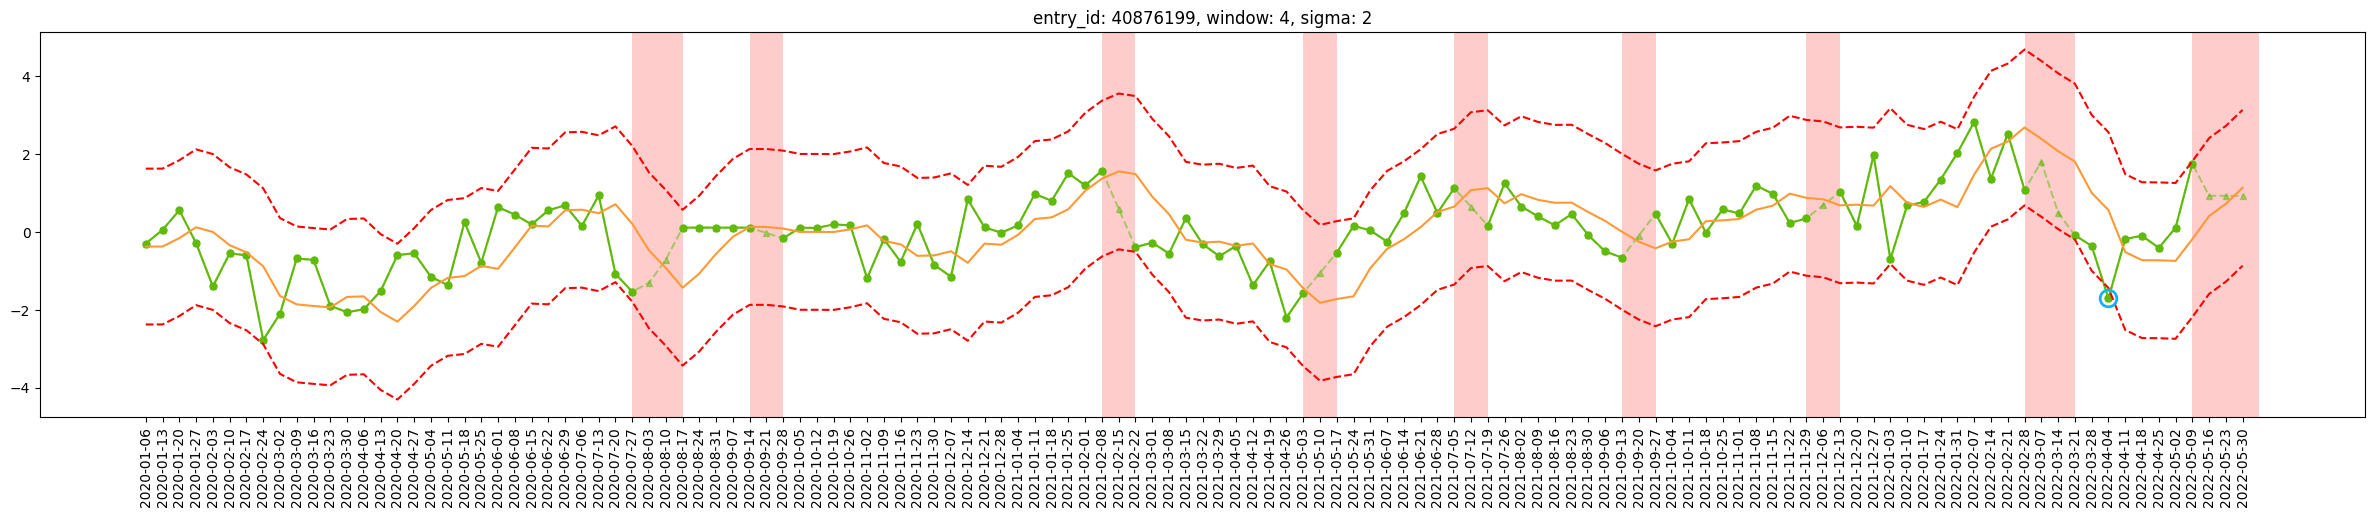

([117],
 117   2022-04-04
 Name: date, dtype: datetime64[ns],
 [3392.6666666667])

In [282]:
outlier_func(df_pivot = df_stats_pivot, entry_id = 40876199, sigma = 2, window = 4, display_plot = True)

# Simple Imputer (Strategy = 'Median')
https://velog.io/@jee-9/%EA%B2%B0%EC%B8%A1%EC%B9%98Nulls-%EC%B2%98%EB%A6%AC%EC%97%90-%EB%8C%80%ED%95%B4%EC%84%9C-Imputation-Single-MICE


# Iterative Imputer
models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature columns is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.


# KNN Imputer
using K-Nearest Neighbors to impute the missing values

Find the best k : https://wikidocs.net/125444

Principle of KNNImputer : https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/

Type of imputation : https://dining-developer.tistory.com/19

In [20]:
# # Simple Inputer
# from sklearn.impute import SimpleImputer
# Raw_simp_median = Raw.copy()
# imputer = SimpleImputer(strategy = 'median')
# Raw_simp_median['price_avg'] = imputer.fit_transform(Raw_simp_median) # np.ndarray
# Raw_simp_median = Raw_simp_median.unstack()

# # Compare Full time period Plot
# plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
# plot_sample_with_ft(Raw_simp_median, 58650041)

# # Compare moving average
# outlier_func(df_pivot['price_avg'].values[~np.isnan(df_pivot['price_avg'].values)], sigma = 2, window = 4, display_plot=True)
# outlier_func(Raw_simp_median['price_avg'].values[0], sigma = 2, window = 4, display_plot=True)

# # IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# Raw_iter = Raw.copy()
# imputer = IterativeImputer(max_iter = 10, random_state = 0)
# Raw_iter['price_avg'] = imputer.fit_transform(Raw_iter)
# Raw_iter = Raw_iter.unstack()

# # # Compare Full time period Plot
# plot_sample_with_ft(df_pivot = df_pivot, entry_id = entry)
# plot_sample_with_ft(Raw_iter, 58650041)

# # Compare moving average
# outlier_func(df_pivot['price_avg'].values[~np.isnan(df_pivot['price_avg'].values)], sigma = 2, window = 4, display_plot=True)
# outlier_func(Raw_simp_iter['price_avg'].values[0], sigma = 2, window = 4, display_plot=True)